# 1. Reading the data from Stage 2 .JSON Output - 325 Companies (Completed 5 yeas)

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
import re
import unicodedata
from pathlib import Path

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm'   # computer modern math
mpl.rcParams['font.serif'] = ['DejaVu Serif']  # fallback, looks similar
mpl.rcParams['axes.unicode_minus'] = False


In [ ]:
!apt-get install texlive texlive-latex-extra texlive-fonts-recommended texlive-fonts-extra dvipng

In [ ]:
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# Root folder that contains company subfolders (e.g. "001. Walmart", etc.)
COMPANIES_ROOT = Path("<<Google Drive Folder>>")

# Locate all Stage 2 result files within the esg_stage2_18(hybrid) folder of each company
files = sorted(COMPANIES_ROOT.glob("*/esg_stage2_18(hybridv5)/*.json"))

# Print the number of files found to help debug
print(f"Found {len(files)} Stage 2 JSON files in esg_stage2_18(hybridv5) folders.")

# 1) Discover all pillar×concept combos from the results
combos = set()
for p in files:
    try:
        j = json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        # Skip files that cannot be read or decoded
        continue
    cov = j.get("coverage") or {}
    for pillar, d in cov.items():
        if isinstance(d, dict):
            for concept in d.keys():
                combos.add((pillar, concept))
combos = sorted(combos)  # stable order

# 2) Build rows (wide)
rows = []
for p in files:
    try:
        j = json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        # Skip files that cannot be read or decoded
        continue

    meta = j.get("meta", {}) or {}
    sic  = (j.get("sic_division") or {}).get("name")
    cov  = j.get("coverage") or {}

    row = {
        "filename": meta.get("filename"),
        "SIC division": sic,
        "year": meta.get("doc_year"),
        "Company code": meta.get("company_code"),
    }

    # For each pillar×concept, pull n_qual/n_qgen/n_qspec (fallback to 0 if absent)
    for pillar, concept in combos:
        st = (cov.get(pillar) or {}).get(concept) or {}
        row[f"{pillar} | {concept} | n_qual"]  = int(st.get("n_qual", 0) or 0)
        row[f"{pillar} | {concept} | n_qgen"]  = int(st.get("n_qgen", 0) or 0)
        row[f"{pillar} | {concept} | n_qspec"] = int(st.get("n_qspec", 0) or 0)

        # If your Stage 2 variant only has "count"/"examples", the above will remain in 0.
        # (That’s OK; it keeps the schema stable across runs.)

    rows.append(row)

df_wide = pd.DataFrame(rows)

# Sort the DataFrame if 'SIC division' column exists and the DataFrame is not empty
if "SIC division" in df_wide.columns and not df_wide.empty:
    df_wide = df_wide.sort_values(
        ["SIC division","year","filename"], na_position="last"
    ).reset_index(drop=True)
elif df_wide.empty:
    print("Warning: DataFrame is empty. Skipping sort.")
else:
     print("Warning: 'SIC division' column not found. Skipping sort.")


In [ ]:
# Create a copy to avoid modifying the original DataFrame
df_modified = df_wide.copy()

# Rename 'filename' to 'company' and extract company name
df_modified['company'] = df_modified['filename'].apply(lambda x: x.split('_')[0])
df_modified = df_modified.drop(columns=['filename'])

# Rename pillars in column names
new_columns = {}
for col in df_modified.columns:
    if 'environmental' in col:
        new_columns[col] = col.replace('environmental', 'ENV')
    elif 'governance' in col:
        new_columns[col] = col.replace('governance', 'GOV')
    elif 'social' in col:
        new_columns[col] = col.replace('social', 'SOC')
    else:
        new_columns[col] = col # Keep other columns as is

df_modified = df_modified.rename(columns=new_columns)

# Reorder columns to make 'company' the first column
cols = df_modified.columns.tolist()
cols.insert(0, cols.pop(cols.index('company')))
df_modified = df_modified[cols]

# Display the modified DataFrame
display(df_modified.head())

# Save to CSV
df_modified.to_csv("esg_stage3v5_wide.csv", index=False)

In [ ]:
# Subset the data into companies with completed ESG report (360)
df_subset = df_modified.copy()

# Convert 'Company code' to string and pad with leading zeros to match '001' format (Original List from Fortune 500)
df_subset['Company code_str'] = df_subset['Company code'].astype(str).str.zfill(3)

# List of companies with completed 5 years ESG report
completed_company_list = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '024', '025', '026', '027', '029', '031', '033', '035', '036', '039', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '072', '075', '076', '077', '080', '081', '083', '084', '086', '088', '089', '090', '092', '093', '094', '095', '096', '098', '099', '100', '101', '102', '103', '107', '108', '110', '116', '117', '118', '119', '120', '121', '122', '124', '125', '126', '127', '128', '131', '132', '134', '137', '138', '139', '144', '145', '147', '149', '150', '152', '155', '156', '157', '158', '159', '161', '162', '163', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '180', '181', '182', '183', '184', '188', '189', '191', '192', '193', '194', '195', '197', '198', '200', '201', '203', '208', '210', '211', '212', '213', '216', '217', '218', '219', '221', '222', '223', '224', '225', '226', '228', '232', '233', '235', '237', '238', '239', '240', '241', '243', '246', '251', '255', '256', '257', '258', '261', '262', '263', '266', '267', '268', '269', '274', '275', '276', '277', '278', '279', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '293', '295', '296', '298', '300', '301', '302', '304', '305', '306', '307', '308', '309', '311', '312', '314', '317', '319', '320', '322', '323', '324', '327', '328', '333', '336', '337', '339', '341', '343', '344', '346', '347', '348', '349', '350', '351', '352', '353', '354', '357', '360', '361', '362', '364', '366', '369', '372', '373', '374', '375', '376', '378', '379', '380', '381', '383', '384', '387', '391', '392', '393', '395', '397', '399', '400', '402', '403', '404', '406', '407', '408', '411', '413', '415', '419', '420', '423', '424', '425', '427', '430', '433', '435', '439', '443', '444', '445', '446', '447', '449', '450', '451', '452', '453', '454', '456', '457', '458', '459', '460', '461', '462', '465', '466', '467', '469', '472', '474', '476', '478', '480', '481', '483', '485', '486', '487', '488', '490', '491', '493', '498', '498', '500']

# Subset the DataFrame based on the list
df_filtered = df_subset[df_subset['Company code_str'].isin(completed_company_list)]

# Display the head of the filtered DataFrame and its shape
print(f"Original df_modified shape: {df_modified.shape}")
print(f"Filtered df_filtered shape: {df_filtered.shape}")
display(df_filtered.head())

# Save to CSV
df_filtered.to_csv("esg_stage3v5_wide(30).csv", index=False)

# 2. Data Preparation for Analysis

In [ ]:
# Load the uploaded file
file_path = "esg_stage3v5_wide(360).csv"
df = pd.read_csv(file_path)

# Filter out year 2025 and 2019
df = df[(df['year'] != 2025) & (df['year'] != 2019)]

# Drop rows where 'year' is NaN before converting to int
df.dropna(subset=['year'], inplace=True)

# Convert 'year' column to integer type
df['year'] = df['year'].astype(int)

df['ENV_total'] = df.filter(like='ENV |').sum(axis=1)
df['SOC_total'] = df.filter(like='SOC |').sum(axis=1)
df['GOV_total'] = df.filter(like='GOV |').sum(axis=1)
df['ESG_total'] = df[['ENV_total', 'SOC_total', 'GOV_total']].sum(axis=1)

df.head()

company                     SIC division  year  \
0               Andersons  Agriculture, Forestry & Fishing  2020   
1  Archer Daniels Midland  Agriculture, Forestry & Fishing  2020   
2                 Corteva  Agriculture, Forestry & Fishing  2020   
3                Seaboard  Agriculture, Forestry & Fishing  2020   
4               Andersons  Agriculture, Forestry & Fishing  2021   

   Company code  ENV | Climate Change Vulnerability | n_qual  \
0           378                                            0   
1            50                                            8   
2           246                                           11   
3           439                                            3   
4           378                                            0   

   ENV | Climate Change Vulnerability | n_qgen  \
0                                            0   
1                                            0   
2                                            1   
3                                            0   
4                                            0   

   ENV | Climate Change Vulnerability | n_qspec  \
0                                             0   
1                                             1   
2                                             2   
3                                             0   
4                                             0   

   ENV | Financing Environmental Impact | n_qual  \
0                                              0   
1                                              0   
2                                              1   
3                                              0   
4                                              0   

   ENV | Financing Environmental Impact | n_qgen  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   ENV | Financing Environmental Impact | n_qspec  ...  \
0                                               0  ...   
1                                               0  ...   
2                                               0  ...   
3                                               0  ...   
4                                               0  ...   

   SOC | SOC values | n_qgen  SOC | SOC values | n_qspec  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          0                           0   

   SOC | well-being | n_qual  SOC | well-being | n_qgen  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   SOC | well-being | n_qspec  Company code_str  ENV_total  SOC_total  \
0                           0               378         45        195   
1                           0                50        558        645   
2                           0               246        828       1133   
3                           0               439         24        146   
4                           0               378        117         33   

   GOV_total  ESG_total  
0        125        365  
1        537       1740  
2        744       2705  
3         62        232  
4         50        200  

[5 rows x 138 columns]

In [ ]:
# --- Helpers ---
def cols(prefix, kind_regex=r'(n_qual|n_qgen|n_qspec)'):
    return df.filter(regex=fr'^{prefix} \| .* \| {kind_regex}$').columns

# Ensure numeric
for prefix in ["ENV", "SOC", "GOV"]:
    for k in ["n_qual", "n_qgen", "n_qspec"]:
        kcols = cols(prefix, k)
        df[kcols] = df[kcols].apply(pd.to_numeric, errors="coerce").fillna(0)

# --- ESG Intensity by Industry (mean totals) ---
E_cols_all = cols("ENV")
S_cols_all = cols("SOC")
G_cols_all = cols("GOV")

# Calculate the percentage share of each pillar for a 100% stacked bar chart
industry_mean = (
    df.groupby("SIC division")[["ENV_total", "SOC_total", "GOV_total", "ESG_total"]]
      .mean()
      .sort_values("ESG_total", ascending=True) # Changed to ascending=True
)
industry_share = industry_mean[["ENV_total", "SOC_total", "GOV_total"]].div(industry_mean["ESG_total"], axis=0) * 100

## Descriptive Statistics

In [ ]:
# Calculate descriptive statistics for the total counts of each pillar in df
pillar_descriptive_stats_df = df[['ENV_total', 'SOC_total', 'GOV_total']].describe().round(2)

# Display the descriptive statistics
print("Descriptive Statistics for Total Hits per Pillar (from df):")
display(pillar_descriptive_stats_df)

Descriptive Statistics for Total Hits per Pillar (from df):


ENV_total  SOC_total  GOV_total
count    1591.00    1591.00    1591.00
mean      569.06     864.69     721.82
std       497.09     578.51     495.68
min         0.00       0.00       0.00
25%       242.00     451.50     385.00
50%       449.00     756.00     645.00
75%       721.00    1157.00     933.00
max      4079.00    3780.00    4499.00

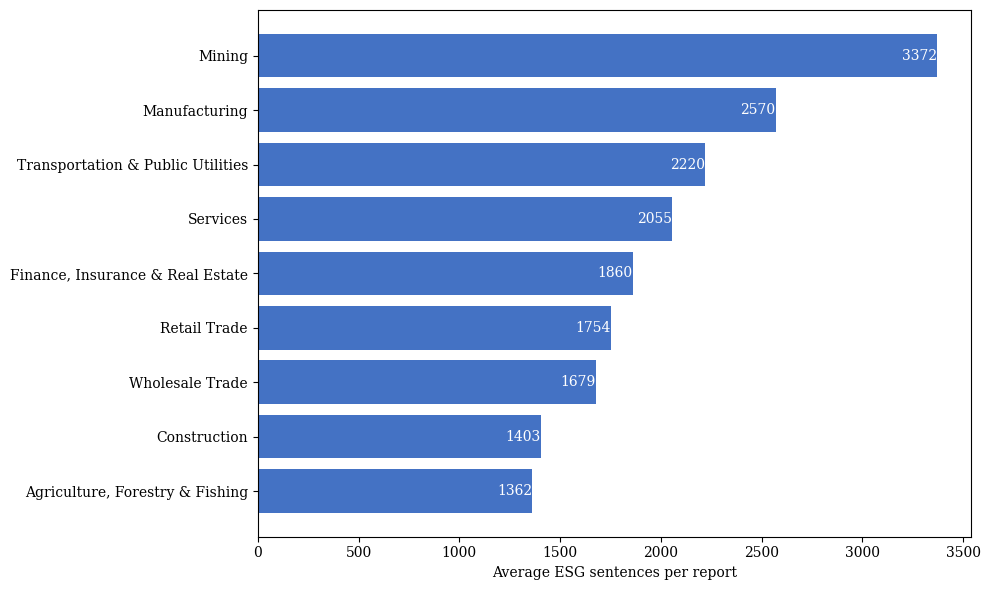

In [ ]:

# Compute total mean ESG sentences per industry
industry_total_mean = (
    industry_mean[["ENV_total", "SOC_total", "GOV_total"]]
    .sum(axis=1)
    .sort_values(ascending=True)   # optional: sort for nicer visual
)

fig, ax = plt.subplots(figsize=(10, 6))
inds = np.arange(len(industry_total_mean))
height = 0.8

# Plot total (one bar only)
bars = ax.barh(
    inds,
    industry_total_mean.values,
    height,
    color="#4472C4"  # choose a single color
)

# Add data labels inside the bar (right side)
for j, total in enumerate(industry_total_mean.values):
    ax.text(
        total - 1,                # inside the bar, near the right edge
        inds[j],
        f"{total:.0f}",             # integer format
        va="center",
        ha="right",
        color="white",
        fontsize=10,
        #fontweight="bold"
    )

# Axis labels and formatting
ax.set_yticks(inds)
ax.set_yticklabels(industry_total_mean.index)
ax.set_xlabel("Average ESG sentences per report")
#ax.set_ylabel("Industry Sector")
#ax.set_title("Total ESG Disclosure by Industry (Mean Sentences per Report)")
plt.tight_layout()
plt.show()


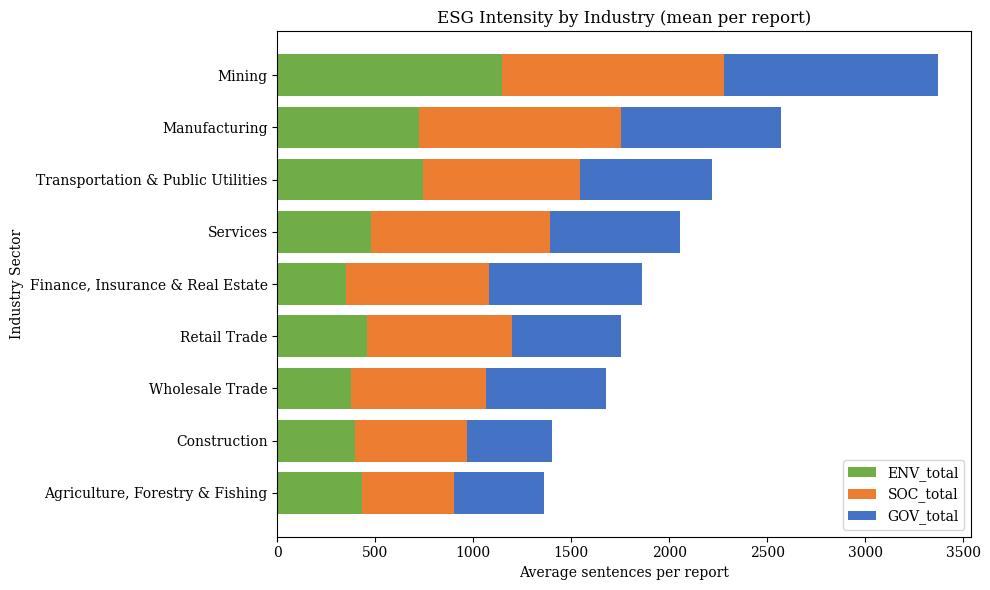

In [ ]:
# Stacked horizontal barchart: mean number of E/S/G sentences per industry
fig1, ax1 = plt.subplots(figsize=(10, 6))
inds = np.arange(len(industry_mean))
left = np.zeros(len(industry_mean))

# Define colors
colors = ["#70AD47",  "#ED7D31", "#4472C4"]
height = 0.8 # Define height of the bars

for i, col in enumerate(["ENV_total", "SOC_total", "GOV_total"]):
    ax1.barh(inds, industry_mean[col].values, height, left=left, label=col, color=colors[i])
    left += industry_mean[col].values

ax1.set_yticks(inds) # Change to set_yticks for horizontal bars
ax1.set_yticklabels(industry_mean.index) # Use yticklabels for industry names
ax1.set_xlabel("Average sentences per report") # Swap x and y labels
ax1.set_ylabel("Industry Sector") # Swap x and y labels
ax1.set_title("ESG Intensity by Industry (mean per report)")
ax1.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-1758994389.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pct = (v / row_totals[j]) * 100


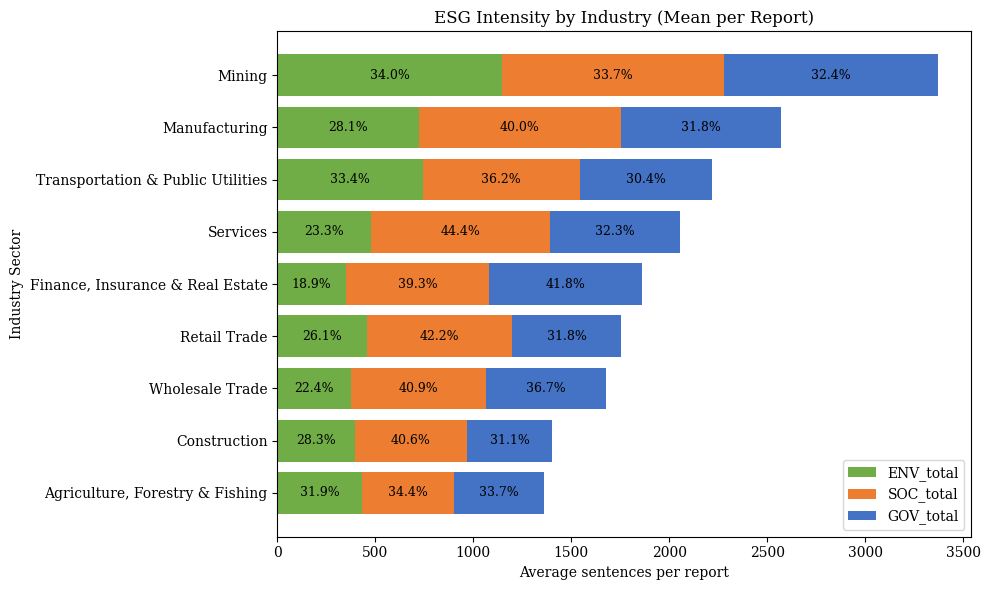

In [ ]:
# Stacked horizontal barchart: mean number of E/S/G sentences per industry
fig1, ax1 = plt.subplots(figsize=(10, 6))
inds = np.arange(len(industry_mean))
height = 0.8

# Define colors
colors = ["#70AD47",  "#ED7D31", "#4472C4"]

# Calculate row totals for percentage labels
row_totals = industry_mean[["ENV_total", "SOC_total", "GOV_total"]].sum(axis=1)

# Track left positions for stacking
left = np.zeros(len(industry_mean))

for i, col in enumerate(["ENV_total", "SOC_total", "GOV_total"]):
    values = industry_mean[col].values
    ax1.barh(inds, values, height, left=left, color=colors[i], label=col)

    # Add percentage labels inside each segment
    for j, v in enumerate(values):
        if v > 0:  # avoid division by zero
            pct = (v / row_totals[j]) * 100
            x_position = left[j] + v / 2  # center of the segment
            ax1.text(
                x_position,
                inds[j],
                f"{pct:.1f}%",
                va='center', ha='center',
                color='black', fontsize=9, #fontweight='bold'
            )

    left += values  # update stacking position

# Axis formatting
ax1.set_yticks(inds)
ax1.set_yticklabels(industry_mean.index)
ax1.set_xlabel("Average sentences per report")
ax1.set_ylabel("Industry Sector")
ax1.set_title("ESG Intensity by Industry (Mean per Report)")
ax1.legend()

plt.tight_layout()
plt.show()


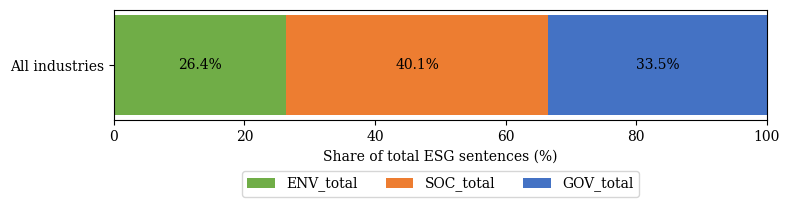

In [ ]:
# --- Composition of Pillars ---
pillar_totals = df[["ENV_total", "SOC_total", "GOV_total"]].sum()
pillar_share = pillar_totals / pillar_totals.sum() * 100

fig2, ax2 = plt.subplots(figsize=(8, 2.5))
# Single 100% stacked horizontal bar
starts = 0
labels = ["ENV_total", "SOC_total", "GOV_total"]
bars = [] # Store bar containers to add labels later
for i, lab in enumerate(labels):
    current_bar = ax2.barh([0], [pillar_share[lab]], left=[starts], label=lab, color=colors[i])
    bars.append(current_bar)
    # Add label in the middle of the current bar segment
    center_x = starts + (pillar_share[lab] / 2)
    ax2.text(center_x, 0, f'{pillar_share[lab]:.1f}%', ha='center', va='center', color='black', fontsize=10)
    starts += pillar_share[lab]
ax2.set_xlim(0, 100)
ax2.set_yticks([0])
ax2.set_yticklabels(["All industries"])
ax2.set_xlabel("Share of total ESG sentences (%)")
#ax2.set_title("Pillar Composition (E / S / G) — Overall")
ax2.legend(ncol=3, bbox_to_anchor=(0.5, -0.4), loc="upper center")
plt.tight_layout()
plt.show()

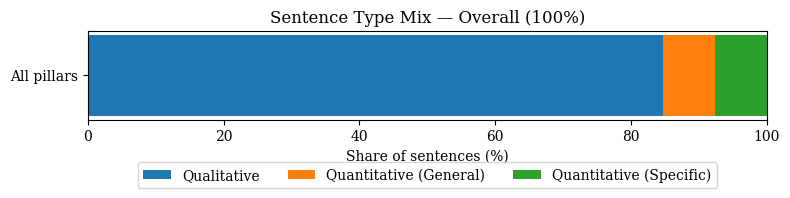

In [ ]:
# --- Sentence Type Mix (Qualitative vs Quantitative) ---
E_qual = df[cols("ENV","n_qual")].sum().sum()
E_qgen = df[cols("ENV","n_qgen")].sum().sum()
E_qspec = df[cols("ENV","n_qspec")].sum().sum()

S_qual = df[cols("SOC","n_qual")].sum().sum()
S_qgen = df[cols("SOC","n_qgen")].sum().sum()
S_qspec = df[cols("SOC","n_qspec")].sum().sum()

G_qual = df[cols("GOV","n_qual")].sum().sum()
G_qgen = df[cols("GOV","n_qgen")].sum().sum()
G_qspec = df[cols("GOV","n_qspec")].sum().sum()

total_qual = E_qual + S_qual + G_qual
total_qgen = E_qgen + S_qgen + G_qgen
total_qspec = E_qspec + S_qspec + G_qspec
mix_total = total_qual + total_qgen + total_qspec

mix_share = {
    "Qualitative": total_qual / mix_total * 100 if mix_total else 0,
    "Quantitative (General)": total_qgen / mix_total * 100 if mix_total else 0,
    "Quantitative (Specific)": total_qspec / mix_total * 100 if mix_total else 0,
}

fig3, ax3 = plt.subplots(figsize=(8, 2.5))
starts = 0
for lab in ["Qualitative", "Quantitative (General)", "Quantitative (Specific)"]:
    ax3.barh([0], [mix_share[lab]], left=[starts], label=lab)
    starts += mix_share[lab]
ax3.set_xlim(0, 100)
ax3.set_yticks([0])
ax3.set_yticklabels(["All pillars"])
ax3.set_xlabel("Share of sentences (%)")
ax3.set_title("Sentence Type Mix — Overall (100%)")
ax3.legend(ncol=3, bbox_to_anchor=(0.5, -0.4), loc="upper center")
plt.tight_layout()
plt.show()


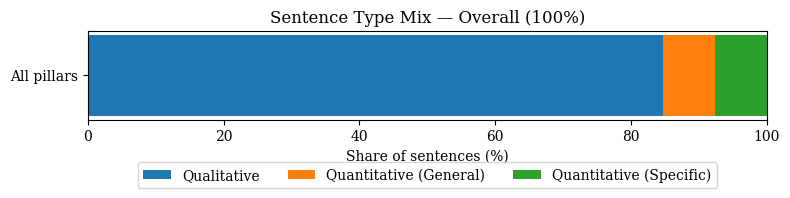

In [ ]:
# --- Sentence Type Mix (Qualitative vs Quantitative) ---
E_qual = df[cols("ENV","n_qual")].sum().sum()
E_qgen = df[cols("ENV","n_qgen")].sum().sum()
E_qspec = df[cols("ENV","n_qspec")].sum().sum()

S_qual = df[cols("SOC","n_qual")].sum().sum()
S_qgen = df[cols("SOC","n_qgen")].sum().sum()
S_qspec = df[cols("SOC","n_qspec")].sum().sum()

G_qual = df[cols("GOV","n_qual")].sum().sum()
G_qgen = df[cols("GOV","n_qgen")].sum().sum()
G_qspec = df[cols("GOV","n_qspec")].sum().sum()

total_qual = E_qual + S_qual + G_qual
total_qgen = E_qgen + S_qgen + G_qgen
total_qspec = E_qspec + S_qspec + G_qspec
mix_total = total_qual + total_qgen + total_qspec

mix_share = {
    "Qualitative": total_qual / mix_total * 100 if mix_total else 0,
    "Quantitative (General)": total_qgen / mix_total * 100 if mix_total else 0,
    "Quantitative (Specific)": total_qspec / mix_total * 100 if mix_total else 0,
}

fig3, ax3 = plt.subplots(figsize=(8, 2.5))
starts = 0
for lab in ["Qualitative", "Quantitative (General)", "Quantitative (Specific)"]:
    ax3.barh([0], [mix_share[lab]], left=[starts], label=lab)
    starts += mix_share[lab]
ax3.set_xlim(0, 100)
ax3.set_yticks([0])
ax3.set_yticklabels(["All pillars"])
ax3.set_xlabel("Share of sentences (%)")
ax3.set_title("Sentence Type Mix — Overall (100%)")
ax3.legend(ncol=3, bbox_to_anchor=(0.5, -0.4), loc="upper center")
plt.tight_layout()
plt.show()


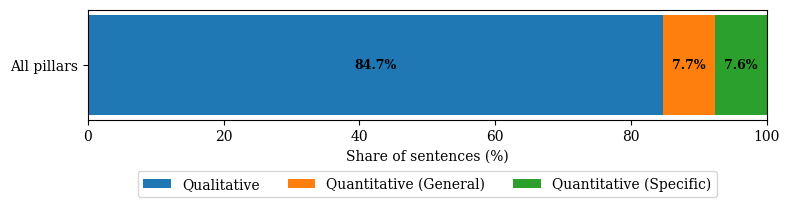

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 2.5))

starts = 0
for lab in ["Qualitative", "Quantitative (General)", "Quantitative (Specific)"]:
    share = mix_share[lab]

    # Draw the bar segment
    ax3.barh([0], [share], left=[starts], label=lab)

    # Add white value label inside the segment
    ax3.text(
        starts + share / 2,   # center of segment
        0,                    # vertical center
        f"{share:.1f}%",      # formatted label
        va='center',
        ha='center',
        color='black',
        fontsize=9,
        fontweight='bold'
    )

    starts += share

# Axis formatting
ax3.set_xlim(0, 100)
ax3.set_yticks([0])
ax3.set_yticklabels(["All pillars"])
ax3.set_xlabel("Share of sentences (%)")
#ax3.set_title("Sentence Type Mix — Overall (100%)")

# Legend formatting
ax3.legend(ncol=3, bbox_to_anchor=(0.5, -0.4), loc="upper center")

plt.tight_layout()
plt.show()


## 2.1 Overview: ESG Intensity by Industry

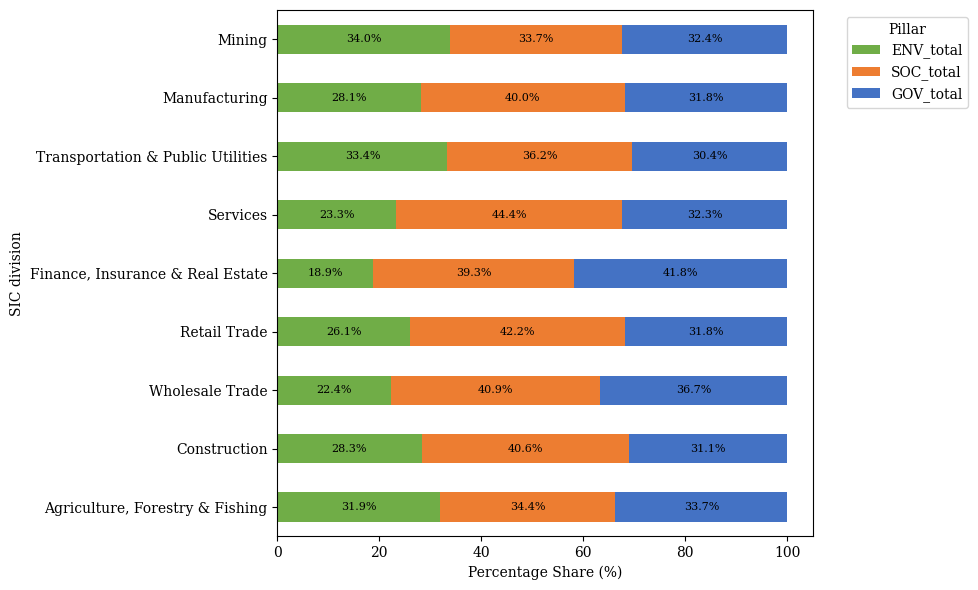

In [ ]:
# Create a figure for the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define custom colors using matplotlib's default color cycle shades
colors = ["#70AD47","#ED7D31", "#4472C4"]

# Plot the 100% stacked horizontal bars with custom colors
industry_share.plot(kind="barh", stacked=True, ax=ax, color=colors)

# Set labels and title
ax.set_xlabel("Percentage Share (%)")
#ax.set_ylabel("Industry Sector")
#ax.set_title("ESG Pillar Composition per Industry Sector")

# Add percentage labels
for container in ax.containers:
    # Iterate through each bar in the container
    for bar in container:
        width = bar.get_width()
        # Only label bars that are wide enough to display text clearly
        if width > 5: # Adjust this threshold as needed
            xval = bar.get_x() + width / 2
            yval = bar.get_y() + bar.get_height() / 2
            ax.text(xval, yval, f'{width:.1f}%', ha='center', va='center', color='black', fontsize=8)

# Adjust legend
ax.legend(title="Pillar", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ensure the layout is tight and display the plot
plt.tight_layout()
plt.show()

## Combines ESG sentnces per industry sector in a facet grid

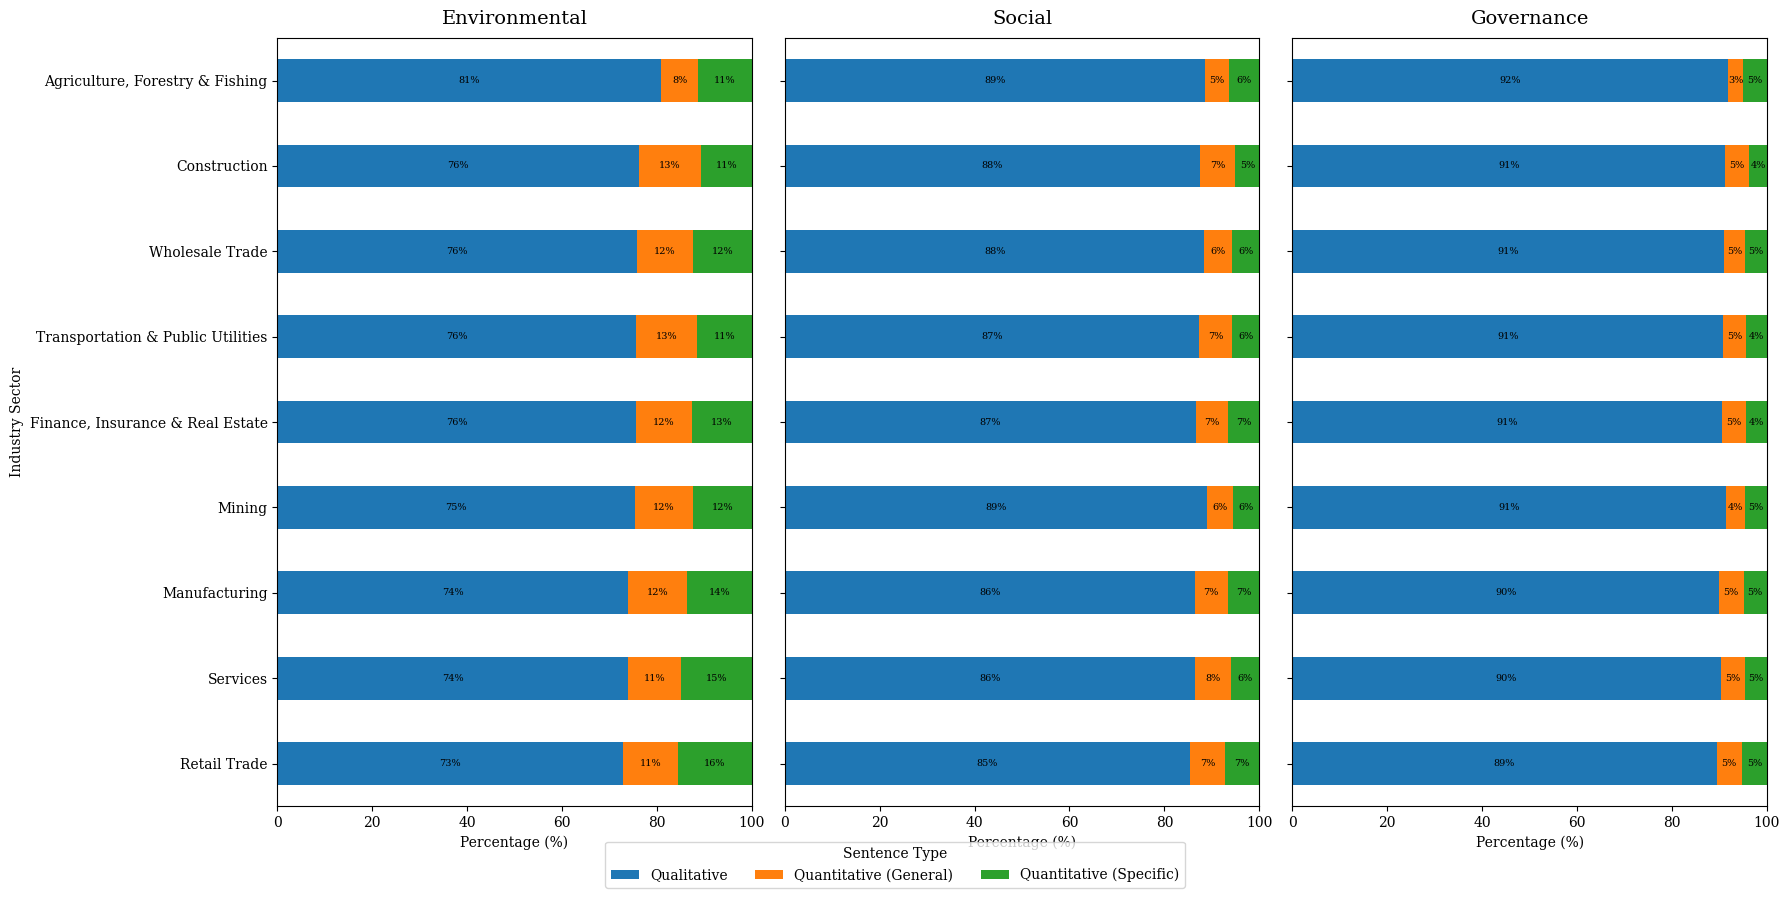

In [ ]:
# Function to prepare % data for each pillar
def pillar_percentage_data(pillar_prefix):
    qual_cols = df.filter(regex=fr'^{pillar_prefix} \| .* \| n_qual$').columns
    qgen_cols = df.filter(regex=fr'^{pillar_prefix} \| .* \| n_qgen$').columns
    qspec_cols = df.filter(regex=fr'^{pillar_prefix} \| .* \| n_qspec$').columns

    summary = df.groupby("SIC division")[[*qual_cols, *qgen_cols, *qspec_cols]].sum()
    summary["Qualitative"] = summary[qual_cols].sum(axis=1)
    summary["Quantitative (General)"] = summary[qgen_cols].sum(axis=1)
    summary["Quantitative (Specific)"] = summary[qspec_cols].sum(axis=1)
    subset = summary[["Qualitative", "Quantitative (General)", "Quantitative (Specific)"]]
    subset_pct = subset.div(subset.sum(axis=1), axis=0) * 100
    return subset_pct.sort_values(by="Qualitative", ascending=True)


# Prepare data for all pillars
env_pct = pillar_percentage_data("ENV")
soc_pct = pillar_percentage_data("SOC")
gov_pct = pillar_percentage_data("GOV")

# Ensure they have the same industry order (based on Environmental for consistency)
industries = env_pct.index

# Create a figure with 3 aligned subplots
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(18, 10))

# Plot each pillar
for ax, data, title in zip(
    axes,
    [env_pct.loc[industries], soc_pct.loc[industries], gov_pct.loc[industries]],
    ["Environmental", "Social", "Governance"]
):
    data.plot(kind="barh", stacked=True, ax=ax, legend=False)
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel("Percentage (%)")
    ax.set_xlim(0, 100)
    ax.set_ylabel("Industry Sector" if ax == axes[0] else "")

    # Add percentage labels
    for container in ax.containers:
        for bar in container:
            width = bar.get_width()
            if width > 3: # Only label bars wide enough to display text clearly
                xval = bar.get_x() + width / 2
                yval = bar.get_y() + bar.get_height() / 2
                ax.text(xval, yval, f'{width:.0f}%', ha='center', va='center', color='black', fontsize=7)

# Shared legend
fig.legend(
    ["Qualitative", "Quantitative (General)", "Quantitative (Specific)"],
    title="Sentence Type",
    bbox_to_anchor=(0.5, 0.05), loc="lower center", ncol=3
)

#plt.suptitle("ESG Pillars — Sentence Type Composition per Industry Sector", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

## 2.2 Trend Overtime

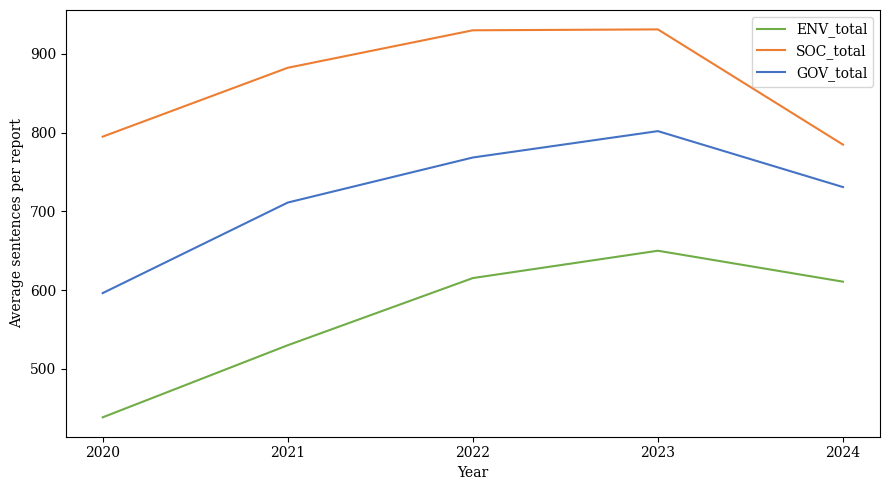

In [ ]:
# Convert year to int
year_series = pd.to_numeric(df["year"], errors="coerce").dropna().astype(int)
df["year_int"] = year_series
yearly = (
    df.dropna(subset=["year_int"])
      .groupby("year_int")[["ENV_total","SOC_total","GOV_total"]]
      .mean()
      .sort_index()
)

# Line chart for E/S/G intensity over time
fig4, ax4 = plt.subplots(figsize=(9, 5))
for i, col in enumerate(["ENV_total","SOC_total","GOV_total"]):
    ax4.plot(yearly.index, yearly[col].values, label=col, color=colors[i])
ax4.set_xlabel("Year")
ax4.set_ylabel("Average sentences per report")
#ax4.set_title("ESG Intensity Over Time (mean per report)")
ax4.legend()
ax4.set_xticks(yearly.index.astype(int)) # Set x-axis ticks to be integers
plt.tight_layout()
plt.show()

/tmp/ipython-input-44446256.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["qual_all"] = df[cols("ENV","n_qual")].sum(axis=1) + df[cols("SOC","n_qual")].sum(axis=1) + df[cols("GOV","n_qual")].sum(axis=1)
/tmp/ipython-input-44446256.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["qgen_all"] = df[cols("ENV","n_qgen")].sum(axis=1) + df[cols("SOC","n_qgen")].sum(axis=1) + df[cols("GOV","n_qgen")].sum(axis=1)
/tmp/ipython-input-44446256.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

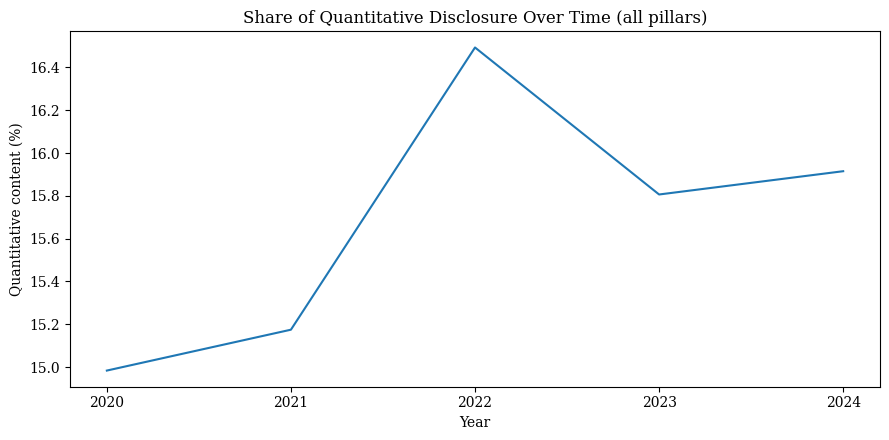

In [ ]:
# Quantitative ratio over time (all pillars combined)
df["qual_all"] = df[cols("ENV","n_qual")].sum(axis=1) + df[cols("SOC","n_qual")].sum(axis=1) + df[cols("GOV","n_qual")].sum(axis=1)
df["qgen_all"] = df[cols("ENV","n_qgen")].sum(axis=1) + df[cols("SOC","n_qgen")].sum(axis=1) + df[cols("GOV","n_qgen")].sum(axis=1)
df["qspec_all"] = df[cols("ENV","n_qspec")].sum(axis=1) + df[cols("SOC","n_qspec")].sum(axis=1) + df[cols("GOV","n_qspec")].sum(axis=1)

num_all = df["qgen_all"] + df["qspec_all"]
den_all = df["qual_all"] + num_all
ratio_all = np.where(den_all == 0, np.nan, num_all / den_all)

ratio_year = (
    pd.DataFrame({"year_int": df["year_int"], "ratio": ratio_all})
      .dropna()
      .groupby("year_int")["ratio"].mean()
)

fig5, ax5 = plt.subplots(figsize=(9, 4.5))
ax5.plot(ratio_year.index, (ratio_year.values*100))
ax5.set_xlabel("Year")
ax5.set_ylabel("Quantitative content (%)")
ax5.set_title("Share of Quantitative Disclosure Over Time (all pillars)")
ax5.set_xticks(ratio_year.index.astype(int)) # Set x-axis ticks to be integers
plt.tight_layout()
plt.show()

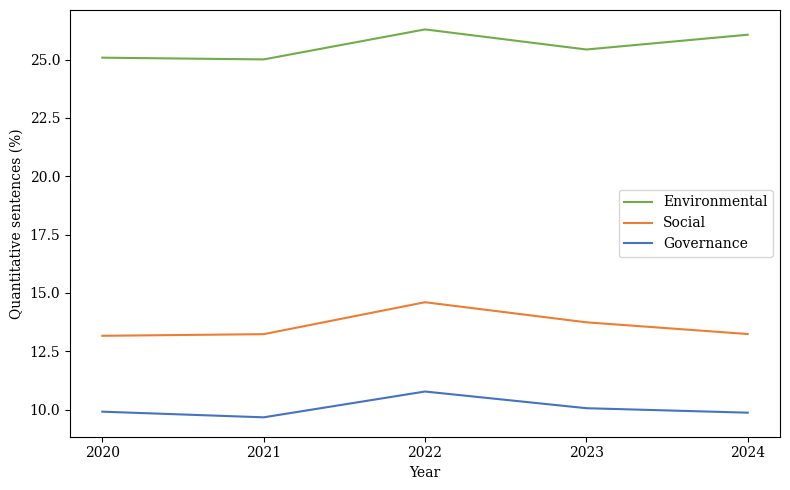

In [ ]:
# Quantitative share by pillar over time
def quant_share_pillar(prefix):
    qgen = df[cols(prefix, "n_qgen")].sum(axis=1)
    qspec = df[cols(prefix, "n_qspec")].sum(axis=1)
    qual = df[cols(prefix, "n_qual")].sum(axis=1)
    num = qgen + qspec
    den = num + qual
    share = np.where(den == 0, np.nan, num / den)
    return (
        pd.DataFrame({"year": df["year"], "share": share})
          .dropna()
          .groupby("year")["share"].mean()
          .sort_index()
    )

env_q = quant_share_pillar("ENV")
soc_q = quant_share_pillar("SOC")
gov_q = quant_share_pillar("GOV")

colors = ["#70AD47","#ED7D31", "#4472C4"]

plt.figure(figsize=(8, 5))
plt.plot(env_q.index, env_q.values * 100, label="Environmental", color='#70AD47')
plt.plot(soc_q.index, soc_q.values * 100, label="Social", color='#ED7D31')
plt.plot(gov_q.index, gov_q.values * 100, label="Governance", color='#4472C4')
plt.xlabel("Year")
#plt.title("Quantitative Share Over Time by Pillar")
plt.ylabel("Quantitative sentences (%)")
plt.legend()
plt.xticks(env_q.index.astype(int)) # Explicitly setting x-axis ticks to integers
plt.tight_layout()
plt.show()

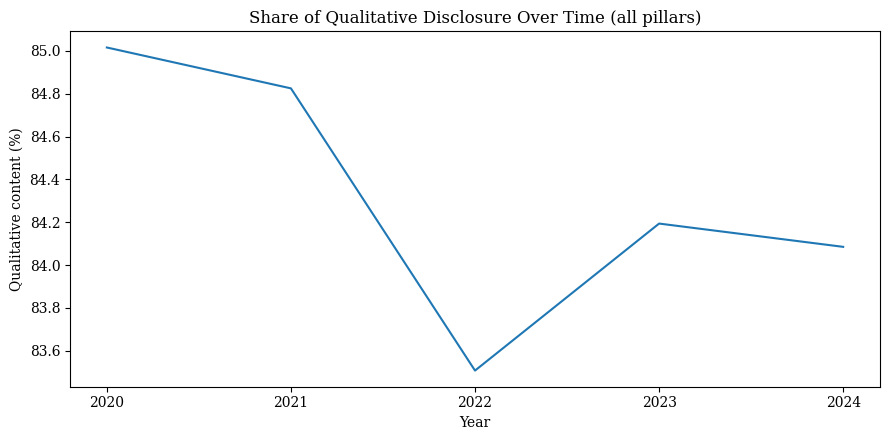

In [ ]:
# Qualitative ratio over time (all pillars combined)
num_all = df["qgen_all"] + df["qspec_all"]
den_all = df["qual_all"] + num_all
ratio_all = np.where(den_all == 0, np.nan, df["qual_all"] / den_all)

ratio_year = (
    pd.DataFrame({"year_int": df["year_int"], "ratio": ratio_all})
      .dropna()
      .groupby("year_int")["ratio"].mean()
)

fig5, ax5 = plt.subplots(figsize=(9, 4.5))
ax5.plot(ratio_year.index, (ratio_year.values*100))
ax5.set_xlabel("Year")
ax5.set_ylabel("Qualitative content (%)")
ax5.set_title("Share of Qualitative Disclosure Over Time (all pillars)")
ax5.set_xticks(ratio_year.index.astype(int)) # Set x-axis ticks to be integers
plt.tight_layout()
plt.show()

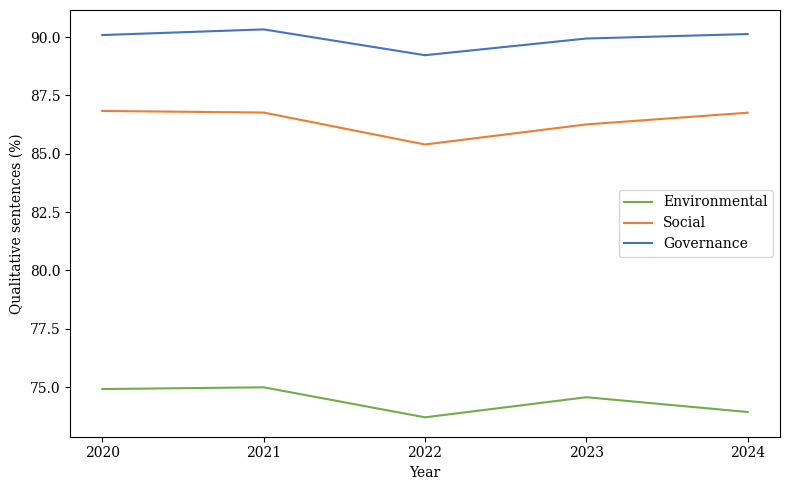

In [ ]:
# Quantitative share by pillar over time
def qual_share_pillar(prefix):
    qgen = df[cols(prefix, "n_qgen")].sum(axis=1)
    qspec = df[cols(prefix, "n_qspec")].sum(axis=1)
    qual = df[cols(prefix, "n_qual")].sum(axis=1)
    num = qgen + qspec
    den = num + qual
    share = np.where(den == 0, np.nan, qual / den)
    return (
        pd.DataFrame({"year": df["year"], "share": share})
          .dropna()
          .groupby("year")["share"].mean()
          .sort_index()
    )

env_qual = qual_share_pillar("ENV")
soc_qual = qual_share_pillar("SOC")
gov_qual = qual_share_pillar("GOV")

plt.figure(figsize=(8, 5))
plt.plot(env_qual.index, env_qual.values * 100, label="Environmental", color='#70AD47')
plt.plot(soc_qual.index, soc_qual.values * 100, label="Social", color='#ED7D31')
plt.plot(gov_qual.index, gov_qual.values * 100, label="Governance", color='#4472C4')
plt.xlabel("Year")
#plt.title("Qualitative Share Over Time by Pillar")
plt.ylabel("Qualitative sentences (%)")
plt.xticks(env_q.index.astype(int)) # Explicitly setting x-axis ticks to integers
plt.legend()
plt.tight_layout()
plt.show()


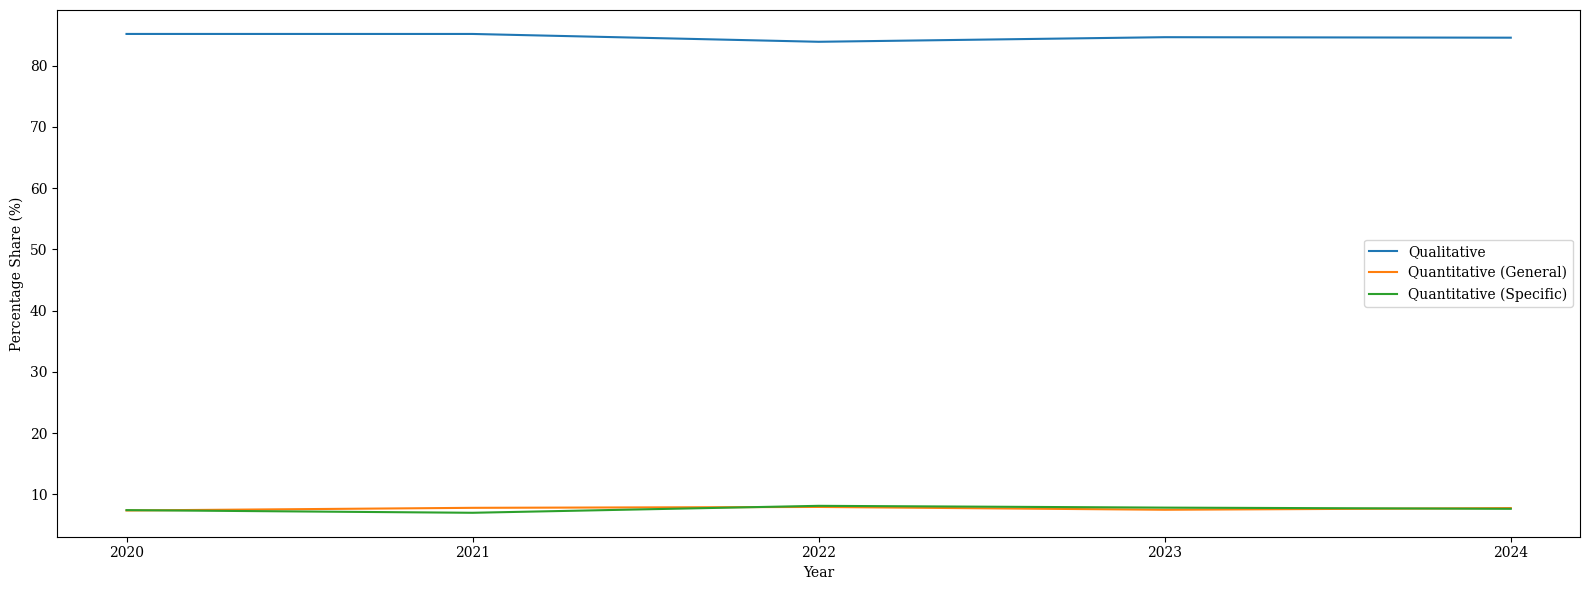

In [ ]:
# Aggregate counts by year for qualitative, quantitative general, and quantitative specific sentences
yearly_sentence_types = df.dropna(subset=["year_int"]).groupby("year_int")[["qual_all", "qgen_all", "qspec_all"]].sum()

# Calculate total for each year
yearly_sentence_types['total'] = yearly_sentence_types[['qual_all', 'qgen_all', 'qspec_all']].sum(axis=1)

# Calculate percentages for each sentence type
yearly_sentence_types['Qualitative'] = (yearly_sentence_types['qual_all'] / yearly_sentence_types['total']) * 100
yearly_sentence_types['Quantitative (General)'] = (yearly_sentence_types['qgen_all'] / yearly_sentence_types['total']) * 100
yearly_sentence_types['Quantitative (Specific)'] = (yearly_sentence_types['qspec_all'] / yearly_sentence_types['total']) * 100

# Select only the percentage columns for plotting
plot_data = yearly_sentence_types[['Qualitative', 'Quantitative (General)', 'Quantitative (Specific)']]

# Plotting the line chart
fig, ax = plt.subplots(figsize=(16, 6))
plot_data.plot(kind='line', ax=ax)

ax.set_xlabel("Year")
ax.set_ylabel("Percentage Share (%)")
#ax.set_title("Share of Sentence Types Over Time (All Pillars Combined)")

# Set x-axis ticks to be integers
ax.set_xticks(plot_data.index.astype(int))

#ax.legend(title="Sentence Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 2.3 Visualise Missing Values

In [ ]:
INPUT_CSV = "esg_stage3v5_wide(360).csv"
df = pd.read_csv(INPUT_CSV)

df = df[(df['year'] != 2025) & (df['year'] != 2019)]

def norm(s: str) -> str:
    return unicodedata.normalize("NFKC", str(s)).strip()

df.columns = [norm(c) for c in df.columns]

# Identify key id columns
cand_sic = [c for c in df.columns if c.lower() in ("sic division","sic division name","sic_division","sic_division_name","sic")]
if not cand_sic:
    raise ValueError("Could not find SIC division column (e.g., 'SIC division').")
sic_col = cand_sic[0]

id_cols = ["company", sic_col, "year"]
id_cols = [c for c in id_cols if c in df.columns]

# Pattern like: "ENV | Climate Change Vulnerability | n_qual"
pat = re.compile(r"^(ENV|SOC|GOV)\s*\|\s*(.+?)\s*\|\s*(n_qual|n_qgen|n_qspec)$", re.IGNORECASE)
pillarmap = {"env":"environmental","soc":"social","gov":"governance"}

concept_cols = []
for c in df.columns:
    if pat.match(c):
        concept_cols.append(c)

if not concept_cols:
    raise ValueError("No concept metric columns matched pattern 'ENV | <concept> | n_qual'.")

rows = []
for c in concept_cols:
    m = pat.match(c)
    abbr = m.group(1).lower()
    pillar = pillarmap.get(abbr, abbr)
    concept = m.group(2).strip()
    metric = m.group(3).lower()
    tmp = df[id_cols + [c]].copy()
    tmp.rename(columns={c:"value"}, inplace=True)
    tmp["pillar"] = pillar
    tmp["concept"] = concept
    tmp["metric"] = metric
    rows.append(tmp)

long_df = pd.concat(rows, ignore_index=True)
long_df["value"] = pd.to_numeric(long_df["value"], errors="coerce").fillna(0)

# Aggregate per document × pillar × concept
agg_cols = id_cols + ["pillar","concept"]
doc_agg = (long_df
           .pivot_table(index=agg_cols, columns="metric", values="value", aggfunc="sum", fill_value=0)
           .reset_index())

for col in ("n_qual","n_qgen","n_qspec"):
    if col not in doc_agg.columns:
        doc_agg[col] = 0

doc_agg["total_hits"] = doc_agg[["n_qual","n_qgen","n_qspec"]].sum(axis=1)
doc_agg["is_missing"] = (doc_agg["total_hits"] <= 0).astype(int)

# Compute missing rate per (pillar, concept, SIC)
grp = (doc_agg
       .groupby([sic_col, "pillar", "concept"], dropna=False)
       .agg(total_docs=("is_missing","size"),
            missing_docs=("is_missing","sum"))
       .reset_index())
grp["missing_rate"] = grp["missing_docs"] / grp["total_docs"]


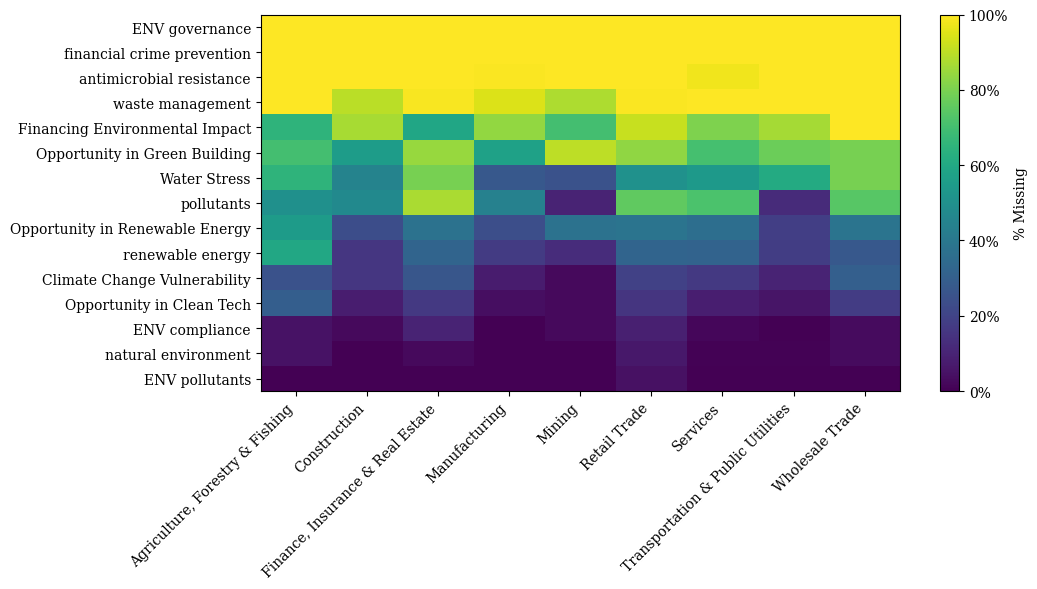

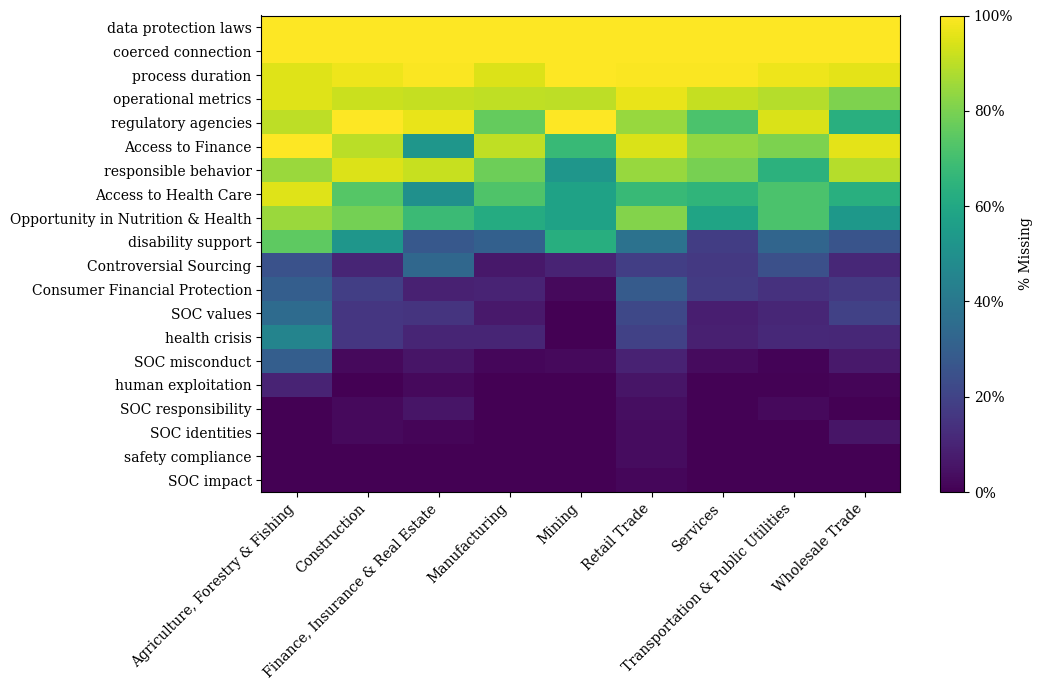

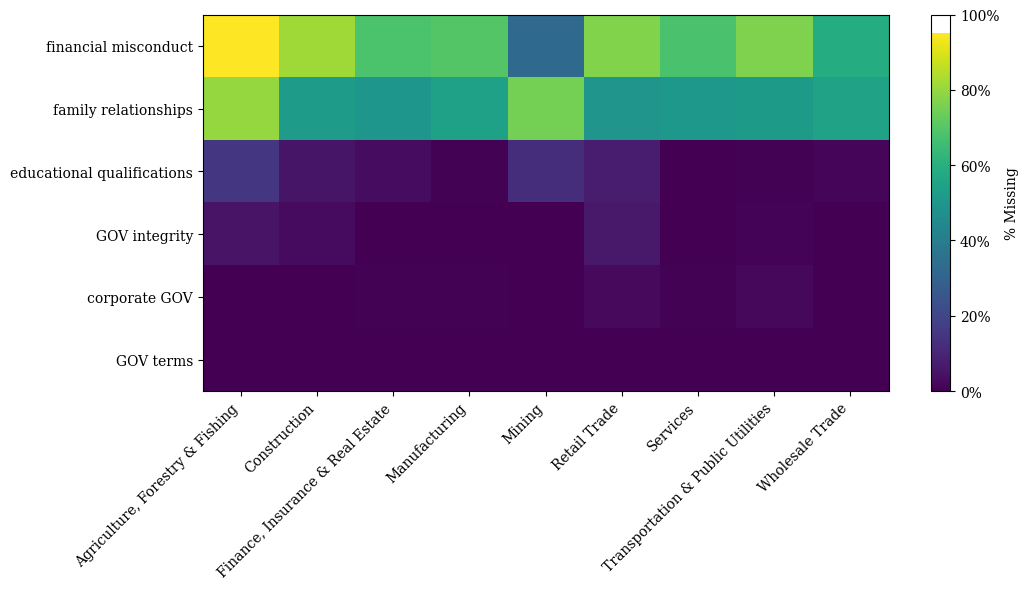

In [ ]:
# Plot heatmap per pillar using matplotlib
def plot_pillar_heatmap(df_pillar: pd.DataFrame, pillar_name: str):
    pivot = df_pillar.pivot_table(index="concept", columns=sic_col, values="missing_rate", aggfunc="mean")
    # Sort concepts by overall missing rate
    order = (df_pillar.groupby("concept")["missing_rate"].mean()
             .sort_values(ascending=False).index.tolist())
    pivot = pivot.reindex(order)
    pivot = pivot.reindex(sorted(pivot.columns, key=lambda x: str(x)), axis=1)

    fig = plt.figure(figsize=(max(8, 1.2*len(pivot.columns)), max(6, 0.35*len(pivot.index))))
    ax = plt.gca()
    data = pivot.to_numpy(dtype=float)
    im = ax.imshow(data, aspect="auto", interpolation="nearest")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("% Missing", rotation=90)
    ticks = np.linspace(0, 1, 6)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])

    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels(pivot.index)

    #ax.set_xlabel("Industry Sector")
    #ax.set_ylabel("Concept")
    #ax.set_title(f"Missing Concepts Heatmap — {pillar_name.capitalize()}")

    # annotate when N is small
    sub = df_pillar.set_index(["concept", sic_col])[["missing_docs","total_docs"]]
    for i, concept in enumerate(pivot.index):
        for j, sic in enumerate(pivot.columns):
            key = (concept, sic)
            if key in sub.index:
                miss = int(sub.loc[key]["missing_docs"])
                tot  = int(sub.loc[key]["total_docs"])
                if tot <= 5:
                    ax.text(j, i, f"{miss}/{tot}", ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()
    plt.close(fig)

for p in ["environmental","social","governance"]:
    dfp = grp[grp["pillar"] == p]
    if dfp.empty:
        continue
    plot_pillar_heatmap(dfp, p)

Top 10 most-missing ENV concepts:
ENV governance                     100.000000
financial crime prevention         100.000000
antimicrobial resistance            99.499374
waste management                    97.559449
Financing Environmental Impact      80.287860
Opportunity in Green Building       71.777222
pollutants                          57.259074
Water Stress                        51.439299
Opportunity in Renewable Energy     31.226533
renewable energy                    25.344180
dtype: float64
ENV missing (%) by industry (first 5 rows, first 5 concepts):
                                  Climate Change Vulnerability  \
SIC division                                                     
Agriculture, Forestry & Fishing                      25.000000   
Construction                                         15.789474   
Finance, Insurance & Real Estate                     27.147766   
Manufacturing                                         7.459677   
Mining                           

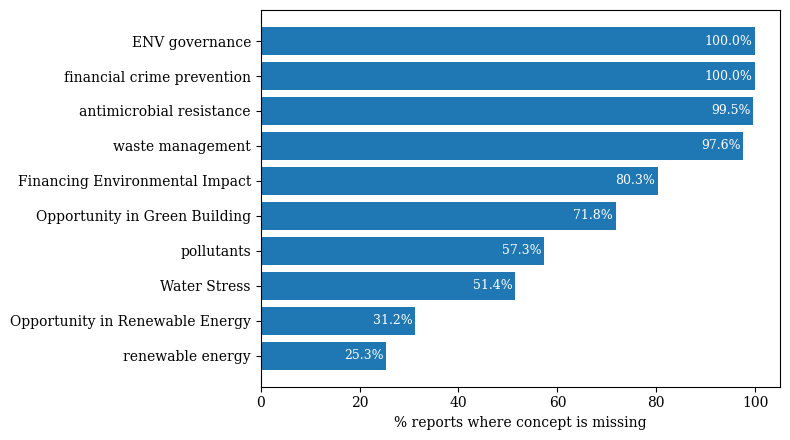

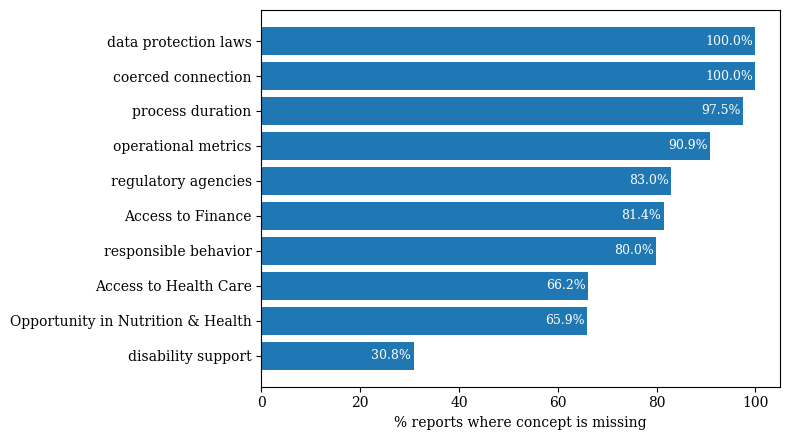

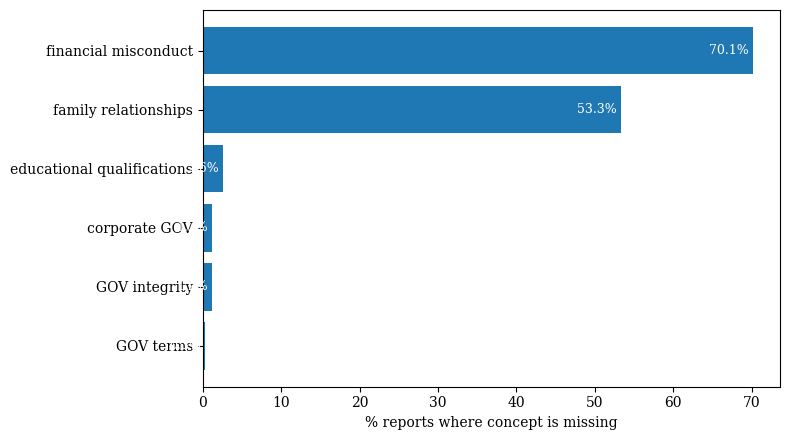

In [ ]:
# STEP 5 – Concept Gap Analysis (minimal working code for Colab)

# ============================================================
# 1. Build “missing concept” binary matrix per pillar
#    missing = 1 if (n_qual + n_qgen + n_qspec == 0), else 0
# ============================================================

def get_concepts(pillar_prefix):
    """Return list of concept names for a pillar, based on the n_qual columns."""
    cols = df.filter(regex=rf'^{pillar_prefix} \| .* \| n_qual$').columns
    # column format: 'ENV | Concept Name | n_qual'
    concepts = [c.split(" | ")[1] for c in cols]
    return concepts

def build_missing_matrix(pillar_prefix):
    """
    Returns:
      missing_df: DataFrame (n_reports x n_concepts) with 1=missing, 0=present
      concepts: list of concept names (in column order)
    """
    concepts = get_concepts(pillar_prefix)
    data = {}
    for concept in concepts:
        c_qual = f"{pillar_prefix} | {concept} | n_qual"
        c_qgen = f"{pillar_prefix} | {concept} | n_qgen"
        c_qspec = f"{pillar_prefix} | {concept} | n_qspec"
        # Handle possible missing columns safely
        for c in [c_qual, c_qgen, c_qspec]:
            if c not in df.columns:
                df[c] = 0
        total = df[c_qual] + df[c_qgen] + df[c_qspec]
        data[concept] = (total == 0).astype(int)  # 1 = missing, 0 = mentioned at least once
    missing_df = pd.DataFrame(data, index=df.index)
    return missing_df, concepts

# Example: build for all three pillars
missing_ENV, env_concepts = build_missing_matrix("ENV")
missing_SOC, soc_concepts = build_missing_matrix("SOC")
missing_GOV, gov_concepts = build_missing_matrix("GOV")

# ============================================================
# 2. % missing by concept (overall, per pillar)
# ============================================================

env_missing_pct_concept = missing_ENV.mean(axis=0) * 100   # Series: concept -> % missing
soc_missing_pct_concept = missing_SOC.mean(axis=0) * 100
gov_missing_pct_concept = missing_GOV.mean(axis=0) * 100

print("Top 10 most-missing ENV concepts:")
print(env_missing_pct_concept.sort_values(ascending=False).head(10))

# ============================================================
# 3. % missing by industry (concept × industry matrix)
# ============================================================

def missing_by_industry(missing_df):
    """
    Returns: DataFrame (industry x concept) with % missing within each industry.
    """
    tmp = missing_df.copy()
    tmp["SIC division"] = df["SIC division"].values
    miss_ind = tmp.groupby("SIC division").mean().drop(columns=["SIC division"], errors="ignore") * 100
    return miss_ind

env_missing_industry = missing_by_industry(missing_ENV)
soc_missing_industry = missing_by_industry(missing_SOC)
gov_missing_industry = missing_by_industry(missing_GOV)

# Example preview
print("ENV missing (%) by industry (first 5 rows, first 5 concepts):")
print(env_missing_industry.iloc[:5, :5])
print(soc_missing_industry.iloc[:5, :5])
print(gov_missing_industry.iloc[:5, :5])



# ============================================================
# 4. Ranked bar charts: top missing concepts per pillar
# ============================================================

def plot_top_missing_bar(missing_pct_series, pillar_name, top_n=10):
    top = missing_pct_series.sort_values(ascending=False).head(top_n)
    fig, ax = plt.subplots(figsize=(8, 4.5))
    bars = ax.barh(top.index, top.values)

    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width - 0.5, # Slightly inside the bar from the right
            bar.get_y() + bar.get_height() / 2,
            f'{width:.1f}%',
            ha='right', va='center', color='white', fontsize=9
        )

    ax.invert_yaxis()  # highest at top
    ax.set_xlabel("% reports where concept is missing")
    #ax.set_title(f"{pillar_name} – Top {top_n} Most-Missing Concepts")
    plt.tight_layout()
    plt.show()

# Examples:
plot_top_missing_bar(env_missing_pct_concept, "Environmental", top_n=10)
plot_top_missing_bar(soc_missing_pct_concept, "Social", top_n=10)
plot_top_missing_bar(gov_missing_pct_concept, "Governance", top_n=6)

## 2.4 Define ESG Metrics

In [ ]:
# --- Helpers to select columns ---
def cols(prefix, kind_regex=r'(n_qual|n_qgen|n_qspec)'):
    return df.filter(regex=fr'^{prefix} \| .* \| {kind_regex}$').columns

# Ensure numeric for all ESG count columns (idempotent)
for prefix in ["ENV", "SOC", "GOV"]:
    for k in ["n_qual", "n_qgen", "n_qspec"]:
        kcols = cols(prefix, k)
        df[kcols] = df[kcols].apply(pd.to_numeric, errors="coerce").fillna(0)

# --- Per-pillar totals (row-wise) ---
df["E_qual"]  = df[cols("ENV","n_qual")].sum(axis=1)
df["E_qgen"]  = df[cols("ENV","n_qgen")].sum(axis=1)
df["E_qspec"] = df[cols("ENV","n_qspec")].sum(axis=1)

df["S_qual"]  = df[cols("SOC","n_qual")].sum(axis=1)
df["S_qgen"]  = df[cols("SOC","n_qgen")].sum(axis=1)
df["S_qspec"] = df[cols("SOC","n_qspec")].sum(axis=1)

df["G_qual"]  = df[cols("GOV","n_qual")].sum(axis=1)
df["G_qgen"]  = df[cols("GOV","n_qgen")].sum(axis=1)
df["G_qspec"] = df[cols("GOV","n_qspec")].sum(axis=1)

df["E_total"] = df[["E_qual","E_qgen","E_qspec"]].sum(axis=1)
df["S_total"] = df[["S_qual","S_qgen","S_qspec"]].sum(axis=1)
df["G_total"] = df[["G_qual","G_qgen","G_qspec"]].sum(axis=1)
df["ESG_total"] = df[["E_total","S_total","G_total"]].sum(axis=1)

# --- ESG Maturity Index (per pillar + overall) ---
def maturity(qgen, qspec, qual):
    denom = qgen + qspec + qual
    num = qgen + 2*qspec
    out = np.where(denom == 0, np.nan, num / denom)
    return out

df["E_maturity"] = maturity(df["E_qgen"], df["E_qspec"], df["E_qual"])
df["S_maturity"] = maturity(df["S_qgen"], df["S_qspec"], df["S_qual"])
df["G_maturity"] = maturity(df["G_qgen"], df["G_qspec"], df["G_qual"])

df["qual_all"] = df["E_qual"] + df["S_qual"] + df["G_qual"]
df["qgen_all"] = df["E_qgen"] + df["S_qgen"] + df["G_qgen"]
df["qspec_all"] = df["E_qspec"] + df["S_qspec"] + df["G_qspec"]
df["ESG_maturity_overall"] = maturity(df["qgen_all"], df["qspec_all"], df["qual_all"])

# --- Disclosure Balance Index (row-wise) ---
num_imbalance = (df["E_total"] - df["S_total"]).abs() + \
                (df["S_total"] - df["G_total"]).abs() + \
                (df["G_total"] - df["E_total"]).abs()
den_imbalance = 3.0 * df["ESG_total"]
dbi = 1.0 - np.where(den_imbalance == 0, np.nan, num_imbalance / den_imbalance)
df["Disclosure_Balance_Index"] = np.clip(dbi, 0, 1)

# --- Quick preview of metrics ---
preview_cols = [
    "company", "SIC division", "year",
    "E_maturity","S_maturity","G_maturity","ESG_maturity_overall",
    "E_total","S_total","G_total","ESG_total",
    "Disclosure_Balance_Index"
]
preview = df[preview_cols].head(12)
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Composite ESG Metrics — Preview", preview)
except Exception as e:
    print("Preview (first 12 rows):")
    print(preview)

# --- Industry-level summary (mean scores) ---
industry_metrics = (
    df.groupby("SIC division")[
        ["E_maturity","S_maturity","G_maturity","ESG_maturity_overall","Disclosure_Balance_Index"]
    ].mean().sort_values("ESG_maturity_overall", ascending=False)
)

try:
    display_dataframe_to_user("Composite ESG Metrics — Industry Means", industry_metrics.reset_index())
except Exception as e:
    print(industry_metrics.head(10))

# --- Save enriched dataset with metrics ---
out_path = "esg_stage3_with_metrics_360.csv"
df.to_csv(out_path, index=False)
out_path


Preview (first 12 rows):
                   company                     SIC division    year  \
0                Andersons  Agriculture, Forestry & Fishing  2020.0   
1   Archer Daniels Midland  Agriculture, Forestry & Fishing  2020.0   
2                  Corteva  Agriculture, Forestry & Fishing  2020.0   
3                 Seaboard  Agriculture, Forestry & Fishing  2020.0   
4                Andersons  Agriculture, Forestry & Fishing  2021.0   
5   Archer Daniels Midland  Agriculture, Forestry & Fishing  2021.0   
6                  Corteva  Agriculture, Forestry & Fishing  2021.0   
7                 Seaboard  Agriculture, Forestry & Fishing  2021.0   
8                Andersons  Agriculture, Forestry & Fishing  2022.0   
9   Archer Daniels Midland  Agriculture, Forestry & Fishing  2022.0   
10                 Corteva  Agriculture, Forestry & Fishing  2022.0   
11                Seaboard  Agriculture, Forestry & Fishing  2022.0   

    E_maturity  S_maturity  G_maturity  ESG_maturit

/tmp/ipython-input-2694862119.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["E_qual"]  = df[cols("ENV","n_qual")].sum(axis=1)
/tmp/ipython-input-2694862119.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["E_qgen"]  = df[cols("ENV","n_qgen")].sum(axis=1)
/tmp/ipython-input-2694862119.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

'esg_stage3_with_metrics_360.csv'

In [ ]:

# ============================================================
# 1. Ensure required columns exist (totals + composite metrics)
# ============================================================

def cols(prefix, kind):
    """Columns like 'ENV | ... | n_qual'."""
    return df.filter(regex=rf'^{prefix} \| .* \| {kind}$').columns

# Make all ESG count columns numeric
for p in ["ENV", "SOC", "GOV"]:
    for k in ["n_qual", "n_qgen", "n_qspec"]:
        c = cols(p, k)
        if len(c):
            df[c] = df[c].apply(pd.to_numeric, errors="coerce").fillna(0)

# Totals per pillar (if not already present)
if "E_total" not in df.columns:
    df["E_total"] = df[cols("ENV", "n_qual")].sum(axis=1) \
                  + df[cols("ENV", "n_qgen")].sum(axis=1) \
                  + df[cols("ENV", "n_qspec")].sum(axis=1)

if "S_total" not in df.columns:
    df["S_total"] = df[cols("SOC", "n_qual")].sum(axis=1) \
                  + df[cols("SOC", "n_qgen")].sum(axis=1) \
                  + df[cols("SOC", "n_qspec")].sum(axis=1)

if "G_total" not in df.columns:
    df["G_total"] = df[cols("GOV", "n_qual")].sum(axis=1) \
                  + df[cols("GOV", "n_qgen")].sum(axis=1) \
                  + df[cols("GOV", "n_qspec")].sum(axis=1)

if "ESG_total" not in df.columns:
    df["ESG_total"] = df[["E_total", "S_total", "G_total"]].sum(axis=1)

# Composite metrics (only recompute if missing)
if "ESG_maturity_overall" not in df.columns or "Disclosure_Balance_Index" not in df.columns:
    def maturity(qgen, qspec, qual):
        denom = qgen + qspec + qual
        num = qgen + 2*qspec
        return np.divide(num, denom,
                         out=np.full_like(denom, np.nan, dtype=float),
                         where=denom != 0)

    # All-pillars maturity
    qgen_all = (df[cols("ENV","n_qgen")].sum(axis=1)
              + df[cols("SOC","n_qgen")].sum(axis=1)
              + df[cols("GOV","n_qgen")].sum(axis=1))
    qspec_all = (df[cols("ENV","n_qspec")].sum(axis=1)
               + df[cols("SOC","n_qspec")].sum(axis=1)
               + df[cols("GOV","n_qspec")].sum(axis=1))
    qual_all = (df[cols("ENV","n_qual")].sum(axis=1)
              + df[cols("SOC","n_qual")].sum(axis=1)
              + df[cols("GOV","n_qual")].sum(axis=1))

    df["ESG_maturity_overall"] = maturity(qgen_all, qspec_all, qual_all)

    # Disclosure balance
    E_tot, S_tot, G_tot = df["E_total"], df["S_total"], df["G_total"]
    imb = (E_tot - S_tot).abs() + (S_tot - G_tot).abs() + (G_tot - E_tot).abs()
    df["Disclosure_Balance_Index"] = np.clip(
        1 - np.divide(imb, 3 * df["ESG_total"],
                      out=np.full_like(df["ESG_total"], np.nan, dtype=float),
                      where=df["ESG_total"] != 0),
        0, 1
    )

# ============================================================
# 2. Industry-level benchmarking table
# ============================================================

industry_metrics = (
    df.groupby("SIC division")[["E_total", "S_total", "G_total",
                                "ESG_total", "ESG_maturity_overall",
                                "Disclosure_Balance_Index"]]
      .agg(["mean", "std"])
      .sort_values(("ESG_maturity_overall", "mean"), ascending=False)
)

# quick look (optional)
print(industry_metrics.head())


                                       E_total                  S_total  \
                                          mean         std         mean   
SIC division                                                              
Retail Trade                        457.314103  420.766042   739.326923   
Mining                             1144.925000  630.189324  1134.700000   
Transportation & Public Utilities   740.816754  521.570254   804.350785   
Manufacturing                       725.290323  572.659717  1027.379032   
Services                            477.968750  402.232328   909.923611   

                                                   G_total              \
                                          std         mean         std   
SIC division                                                             
Retail Trade                       565.975813   557.128205  362.101905   
Mining                             832.208560  1092.325000  727.856896   
Transportation & Public Utili

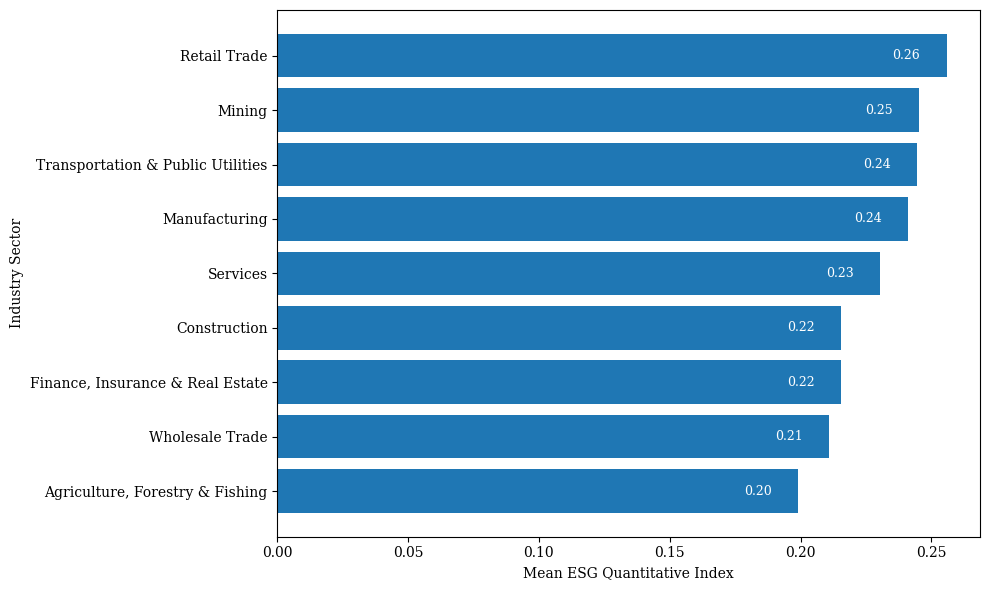

In [ ]:

# ============================================================
# 3. Bar chart: mean ESG maturity per industry
# ============================================================

maturity_mean = (
    df.groupby("SIC division")["ESG_maturity_overall"]
      .mean()
      .sort_values(ascending=True)
)

plt.figure(figsize=(10, 6))
ax = plt.gca() # Get current axes to add text

bars = ax.barh(maturity_mean.index, maturity_mean.values)
plt.ylabel("Industry Sector")
plt.xlabel("Mean ESG Quantitative Index")
#plt.title("ESGQI Industry Comparison (mean per report)")

# Add numerical labels inside the bars
for bar in bars:
    width = bar.get_width()
    # Position the text slightly inside the bar, centered vertically
    ax.text(
        width - 0.01, # x-position (0.01 is a small offset from the right edge)
        bar.get_y() + bar.get_height() / 2, # y-position (center of the bar)
        f'{width:.2f}', # formatted value, 2 decimal places
        ha='right', # horizontal alignment
        va='center', # vertical alignment
        color='white', # text color for contrast
        fontsize=9
    )

plt.tight_layout()
plt.show()

/tmp/ipython-input-2131193816.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


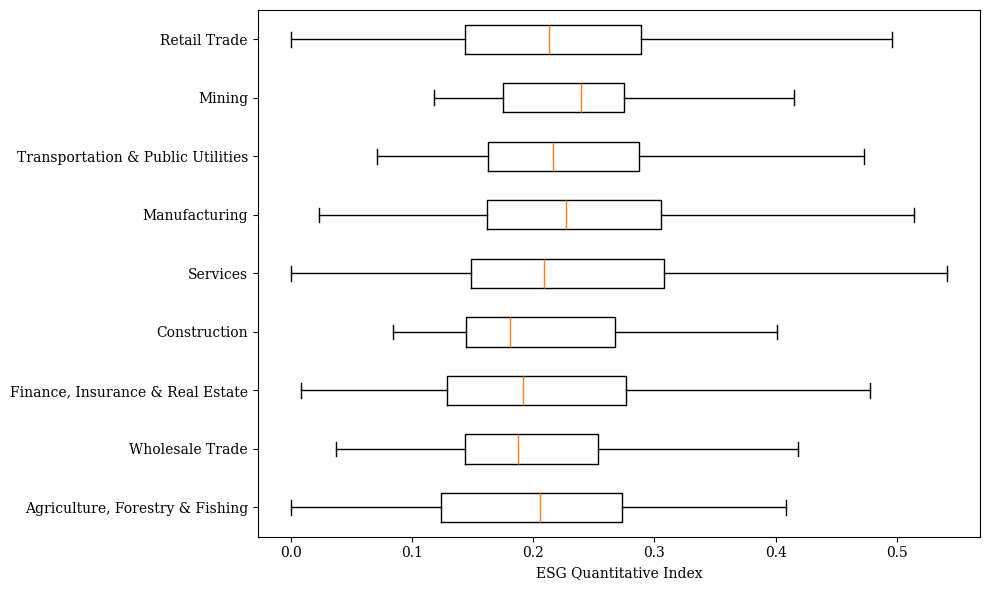

In [ ]:
# ============================================================
# 4. Boxplot: distribution of ESG maturity by industry
# ============================================================

plt.figure(figsize=(10, 6))

# Prepare data in the same industry order
industries = maturity_mean.index
data = [
    df.loc[df["SIC division"] == ind, "ESG_maturity_overall"].dropna()
    for ind in industries
]

# Horizontal boxplot
plt.boxplot(
    data,
    labels=industries,
    vert=False,          # horizontal
    showfliers=False
)

plt.xlabel("ESG Quantitative Index")
#plt.ylabel("Industry Sector")
#plt.title("Boxplot of ESG Quantitative Index Industry Comparison")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 5. Helper: Top N companies within each industry
# ============================================================

def top_companies_by_industry(n=3, metric="ESG_maturity_overall"):
    """Return top-n companies per industry by given metric."""
    cols_keep = ["company", "SIC division", "year", metric]
    df_sorted = df[cols_keep].dropna(subset=[metric]).sort_values(
        ["SIC division", metric], ascending=[True, False]
    )
    return df_sorted.groupby("SIC division").head(n)

top3 = top_companies_by_industry(n=3, metric="ESG_maturity_overall")
print(top3.head(20))  # preview

                     company                      SIC division    year  \
12                 Andersons   Agriculture, Forestry & Fishing  2023.0   
5     Archer Daniels Midland   Agriculture, Forestry & Fishing  2021.0   
9     Archer Daniels Midland   Agriculture, Forestry & Fishing  2022.0   
31                     Fluor                      Construction  2021.0   
30                     EMCOR                      Construction  2021.0   
49          Vulcan Materials                      Construction  2023.0   
72           Elevance Health  Finance, Insurance & Real Estate  2020.0   
157                 Prologis  Finance, Insurance & Real Estate  2021.0   
330                 Prologis  Finance, Insurance & Real Estate  2024.0   
665             Berry Global                     Manufacturing  2023.0   
399                  Hershey                     Manufacturing  2020.0   
534                  PepsiCo                     Manufacturing  2021.0   
861                     Hess          

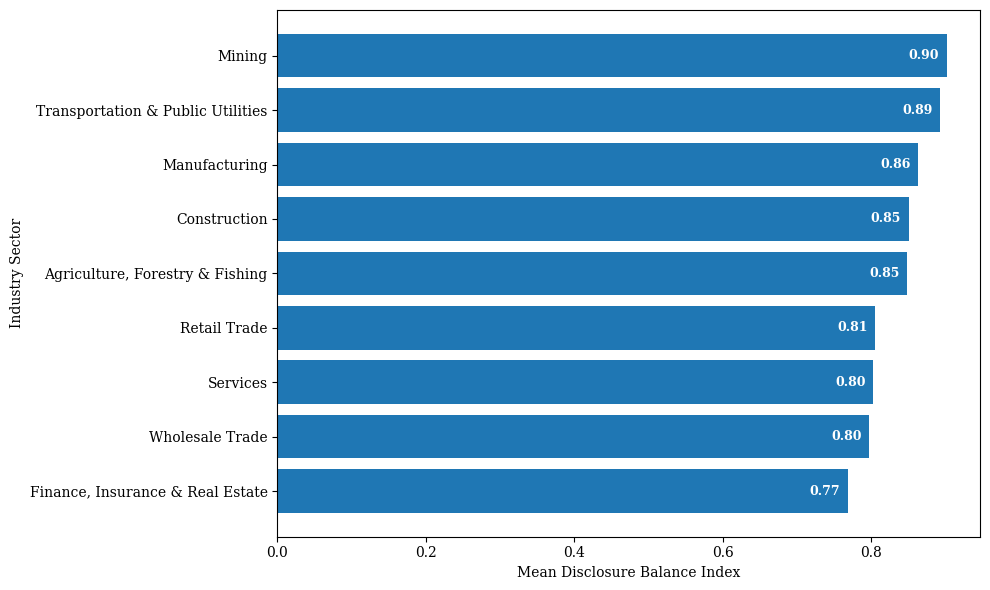

/tmp/ipython-input-2790765277.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=industries, vert=False, showfliers=False)


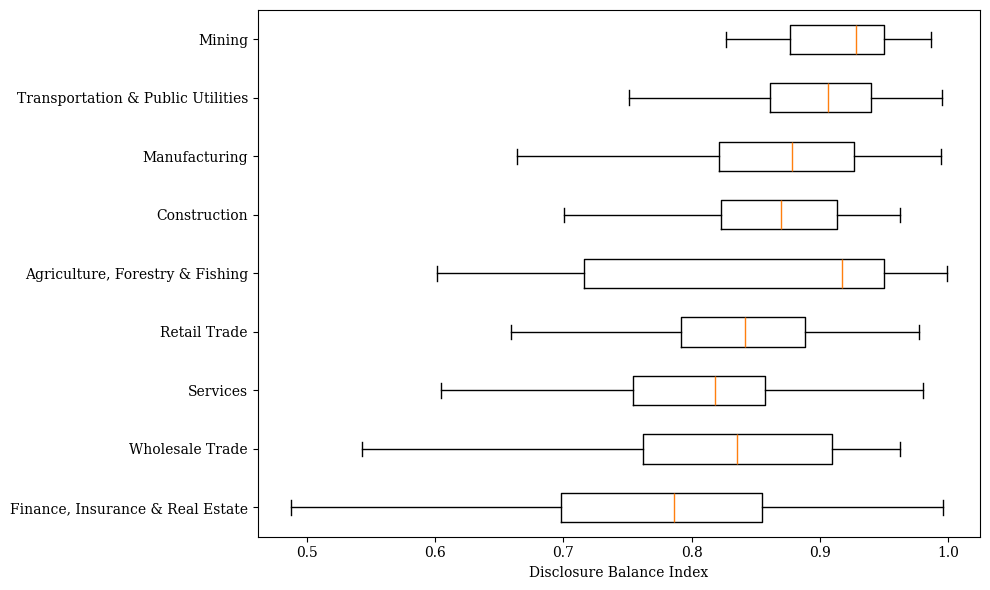

In [ ]:
# ============================ Helpers and Recalculations for Disclosure_Balance_Index ============================
# Re-define cols helper in case the kernel state reset
def cols(prefix, kind_regex=r'(n_qual|n_qgen|n_qspec)'):
    return df.filter(regex=fr'^{prefix} \| .* \| {kind_regex}$').columns

# Ensure numeric for all ESG count columns (idempotent)
for prefix in ["ENV", "SOC", "GOV"]:
    for k in ["n_qual", "n_qgen", "n_qspec"]:
        kcols = cols(prefix, k)
        df[kcols] = df[kcols].apply(pd.to_numeric, errors="coerce").fillna(0)

# --- Per-pillar totals (row-wise) ---
# Check if E_total, S_total, G_total, ESG_total exist, if not, calculate them
if "E_total" not in df.columns:
    df["E_total"] = df[cols("ENV","n_qual")].sum(axis=1) + df[cols("ENV","n_qgen")].sum(axis=1) + df[cols("ENV","n_qspec")].sum(axis=1)
if "S_total" not in df.columns:
    df["S_total"] = df[cols("SOC","n_qual")].sum(axis=1) + df[cols("SOC","n_qgen")].sum(axis=1) + df[cols("SOC","n_qspec")].sum(axis=1)
if "G_total" not in df.columns:
    df["G_total"] = df[cols("GOV","n_qual")].sum(axis=1) + df[cols("GOV","n_qgen")].sum(axis=1) + df[cols("GOV","n_qspec")].sum(axis=1)
if "ESG_total" not in df.columns:
    df["ESG_total"] = df[["E_total","S_total","G_total"]].sum(axis=1)

# --- Disclosure Balance Index (row-wise) ---
# Check if Disclosure_Balance_Index exists, if not, calculate it
if "Disclosure_Balance_Index" not in df.columns:
    num_imbalance = (df["E_total"] - df["S_total"]).abs() + \
                    (df["S_total"] - df["G_total"]).abs() + \
                    (df["G_total"] - df["E_total"]).abs()
    den_imbalance = 3.0 * df["ESG_total"]
    dbi = 1.0 - np.where(den_imbalance == 0, np.nan, num_imbalance / den_imbalance)
    df["Disclosure_Balance_Index"] = np.clip(dbi, 0, 1)

# ============================ Original Plotting Code ============================

# ============================
# 1. Bar chart: mean DBI by industry
# ============================

# Compute mean DBI per industry (ascending order)
dbi_mean = (
    df.groupby("SIC division")["Disclosure_Balance_Index"]
      .mean()
      .sort_values(ascending=True)
)

plt.figure(figsize=(10, 6))
bars = plt.barh(dbi_mean.index, dbi_mean.values)

# Add value labels inside each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width - 0.01,                        # slightly to the left of the bar end
        bar.get_y() + bar.get_height() / 2,  # vertical center
        f"{width:.2f}",                       # formatted value
        ha='right', va='center',
        color='white', fontsize=9, fontweight='bold'
    )

plt.xlabel("Mean Disclosure Balance Index")
plt.ylabel("Industry Sector")
#plt.title("Disclosure Balance Index - Industry Comparison")
plt.yticks(ticks=dbi_mean.index, labels=dbi_mean.index) # Add this line to set y-axis labels
plt.tight_layout()
plt.show()

# ============================
# 2. Boxplot: DBI distribution by industry
# ============================

# Industry order based on ascending DBI mean
industries = dbi_mean.index.tolist()

# Prepare data in sorted order
box_data = [
    df.loc[df["SIC division"] == ind, "Disclosure_Balance_Index"].dropna()
    for ind in industries
]

plt.figure(figsize=(10, 6))
plt.boxplot(box_data, labels=industries, vert=False, showfliers=False)
plt.xlabel("Disclosure Balance Index")
#plt.ylabel("Industry Sector")
#plt.title("Boxplot of Distribution of Disclosure Balance Index by Industry")
plt.tight_layout()
plt.show()

## 2.5 Cross Pillar Analysis

### Slope Graph of Two Time Period (2020 - 2024)

In [ ]:
df_melted_sectors_filtered_years = df_melted_sectors[df_melted_sectors['year'].isin([2020, 2024])]
display(df_melted_sectors_filtered_years.head())

year                     SIC division  \
0   2020.0  Agriculture, Forestry & Fishing   
1   2020.0  Agriculture, Forestry & Fishing   
2   2020.0  Agriculture, Forestry & Fishing   
3   2020.0  Agriculture, Forestry & Fishing   
16  2024.0  Agriculture, Forestry & Fishing   

                            pillar_concept_type  count pillar  \
0   ENV | Climate Change Vulnerability | n_qual      0    ENV   
1   ENV | Climate Change Vulnerability | n_qual      8    ENV   
2   ENV | Climate Change Vulnerability | n_qual     11    ENV   
3   ENV | Climate Change Vulnerability | n_qual      3    ENV   
16  ENV | Climate Change Vulnerability | n_qual      3    ENV   

                         concept  
0   Climate Change Vulnerability  
1   Climate Change Vulnerability  
2   Climate Change Vulnerability  
3   Climate Change Vulnerability  
16  Climate Change Vulnerability

In [ ]:
df_concept_slope_aggregated = df_melted_sectors_filtered_years.groupby(['year', 'SIC division', 'pillar', 'concept'])['count'].mean().reset_index()
display(df_concept_slope_aggregated.head())

year                     SIC division pillar  \
0  2020.0  Agriculture, Forestry & Fishing    ENV   
1  2020.0  Agriculture, Forestry & Fishing    ENV   
2  2020.0  Agriculture, Forestry & Fishing    ENV   
3  2020.0  Agriculture, Forestry & Fishing    ENV   
4  2020.0  Agriculture, Forestry & Fishing    ENV   

                          concept      count  
0    Climate Change Vulnerability   2.166667  
1                  ENV compliance  14.000000  
2                  ENV governance   0.000000  
3                  ENV pollutants  82.750000  
4  Financing Environmental Impact   0.083333

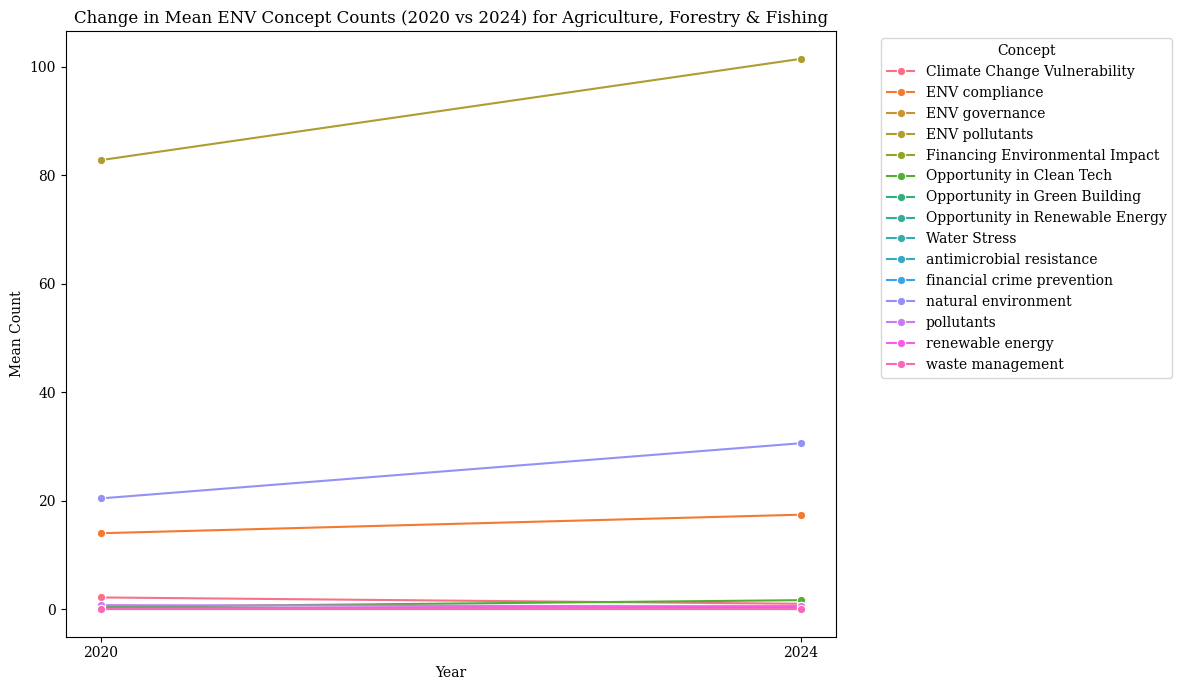

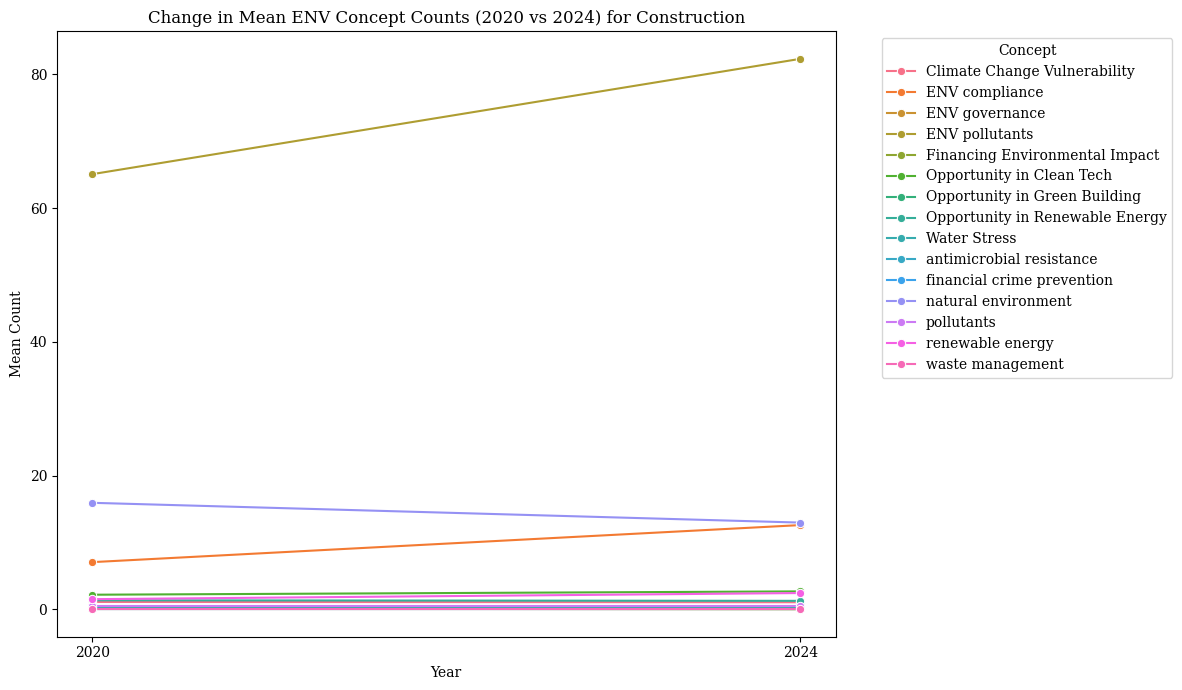

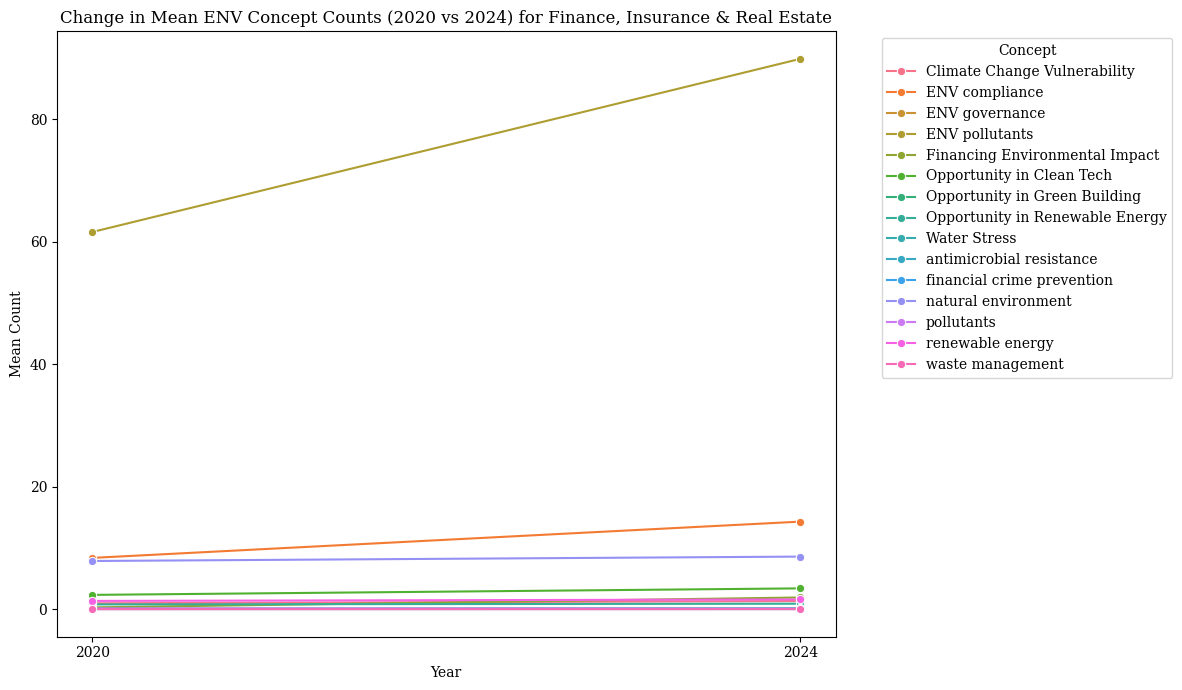

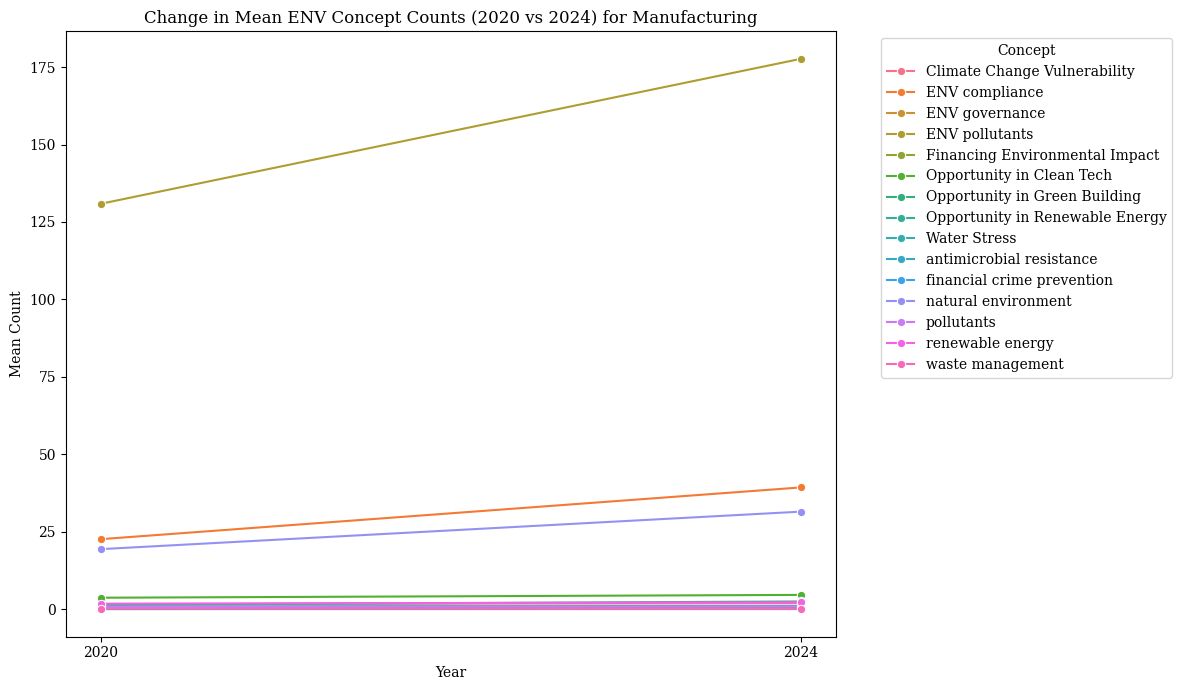

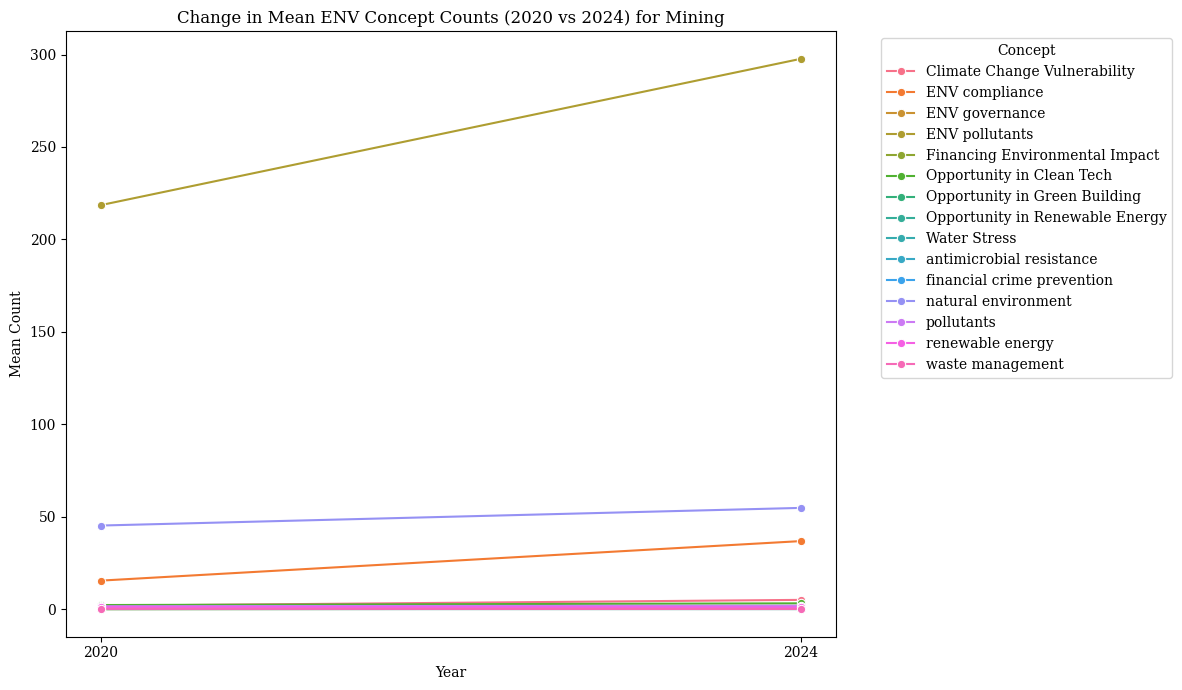

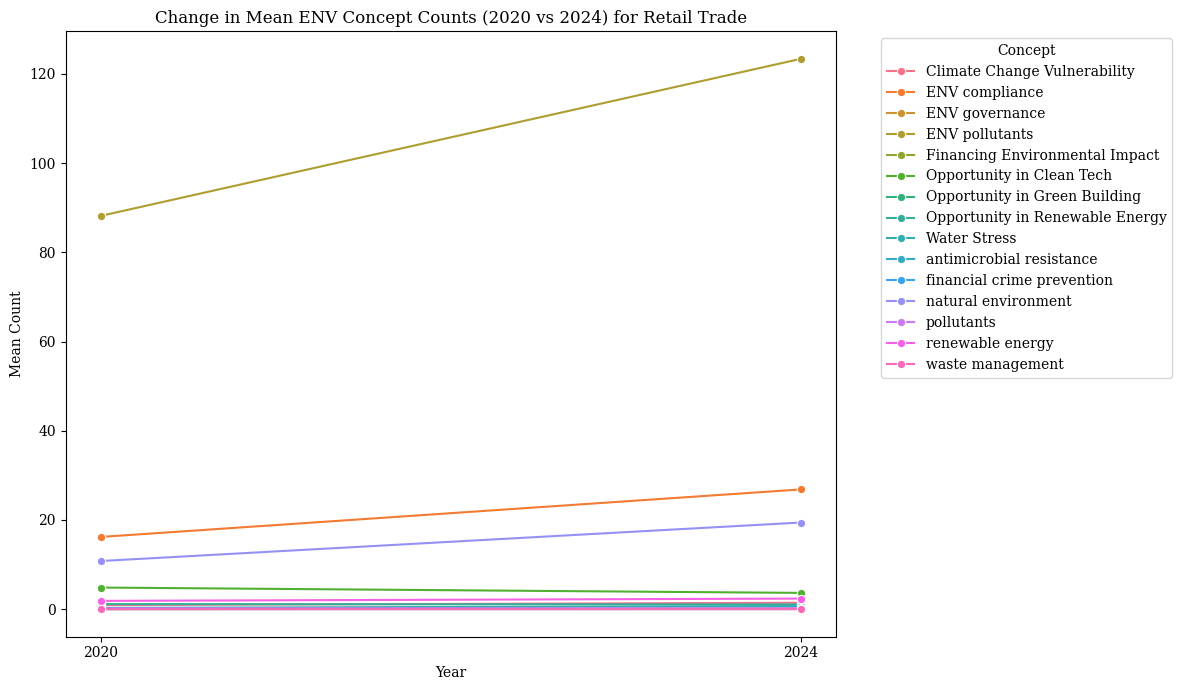

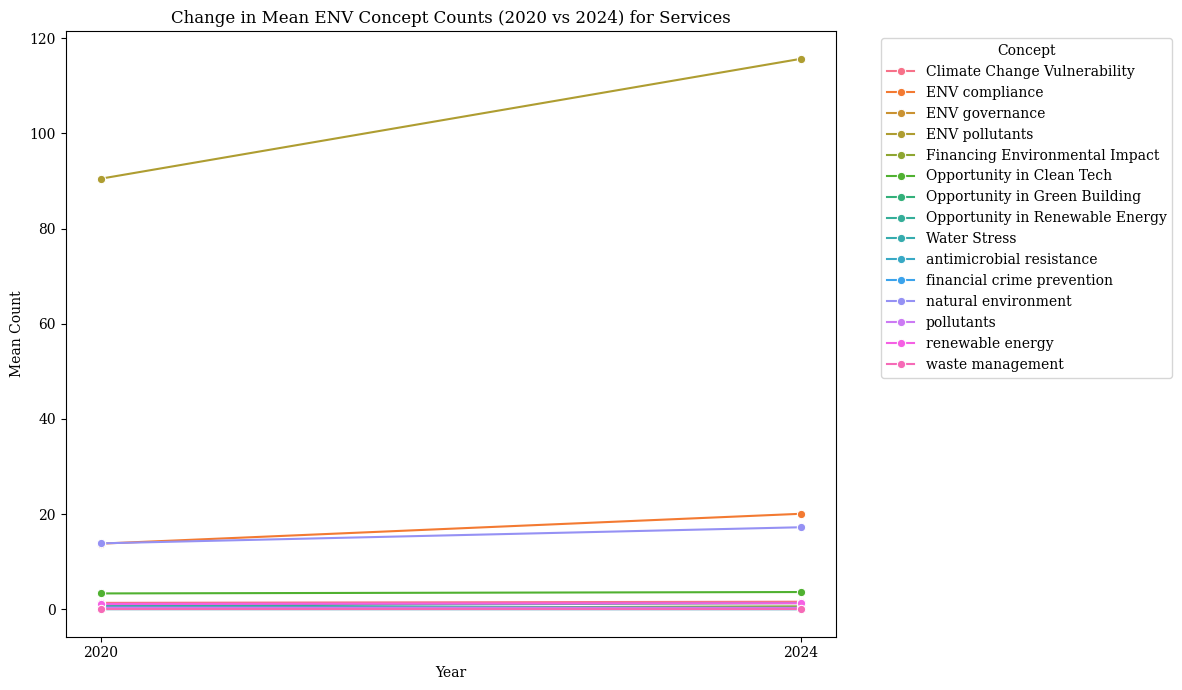

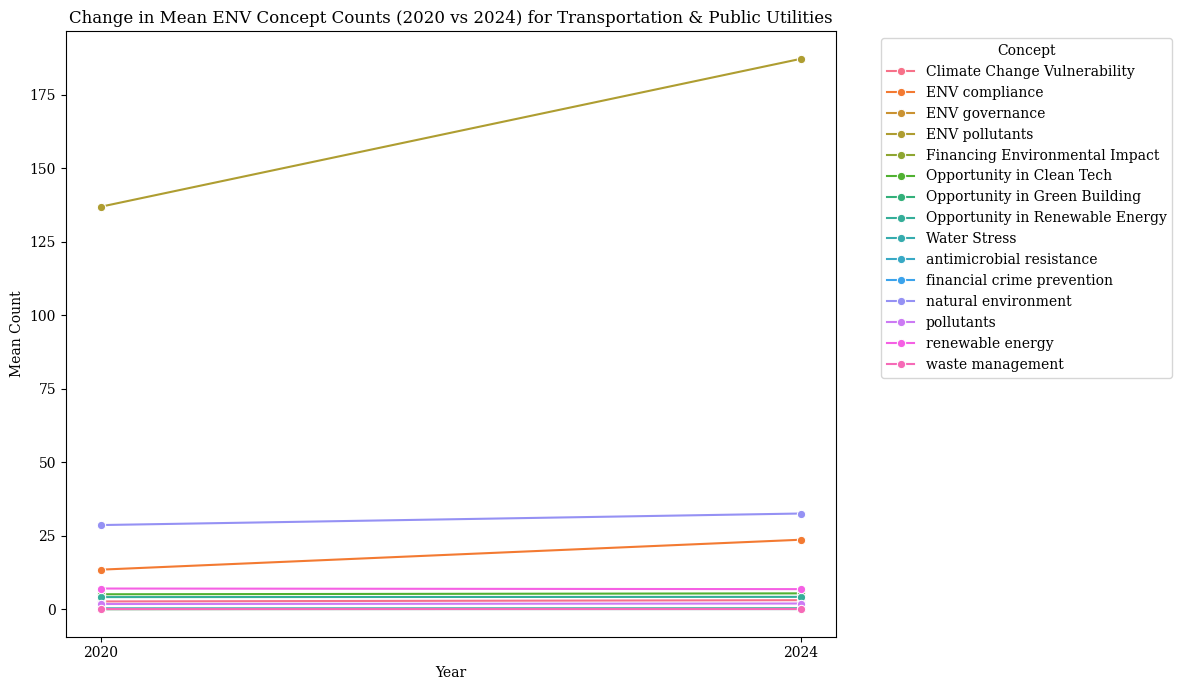

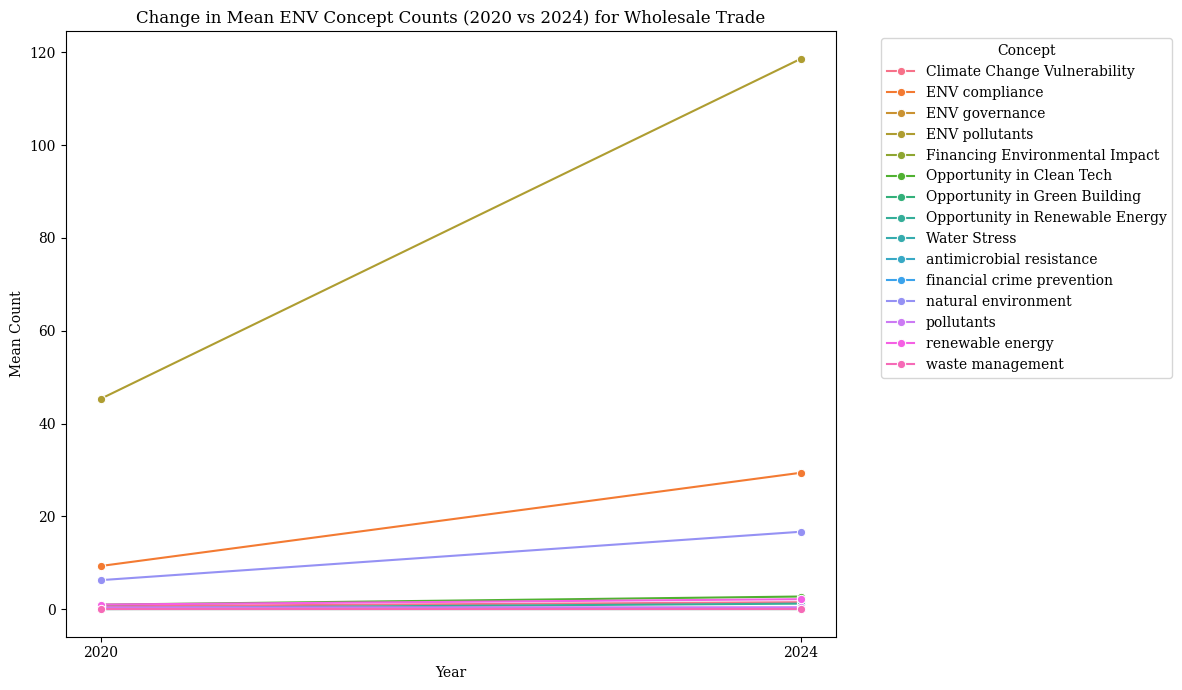

In [ ]:
# Filter the df_concept_slope_aggregated DataFrame to include only rows where the 'pillar' column is 'ENV'.
df_env_concepts_slope = df_concept_slope_aggregated[df_concept_slope_aggregated['pillar'] == 'ENV']

# Get unique SIC divisions
sic_divisions_env = df_env_concepts_slope['SIC division'].unique()

# Create a slope graph for each SIC division
for sic in sic_divisions_env:
    df_sic_env = df_env_concepts_slope[df_env_concepts_slope['SIC division'] == sic]

    # Only plot if there's data for both 2020 and 2024 for at least one concept
    if len(df_sic_env['year'].unique()) == 2:
        plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
        sns.lineplot(data=df_sic_env, x='year', y='count', hue='concept', marker='o')

        # Set title and labels
        plt.title(f'Change in Mean ENV Concept Counts (2020 vs 2024) for {sic}')
        plt.xlabel('Year')
        plt.ylabel('Mean Count')
        plt.xticks([2020, 2024]) # Set x-axis ticks to only 2020 and 2024

        # Adjust legend and layout
        plt.legend(title='Concept', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

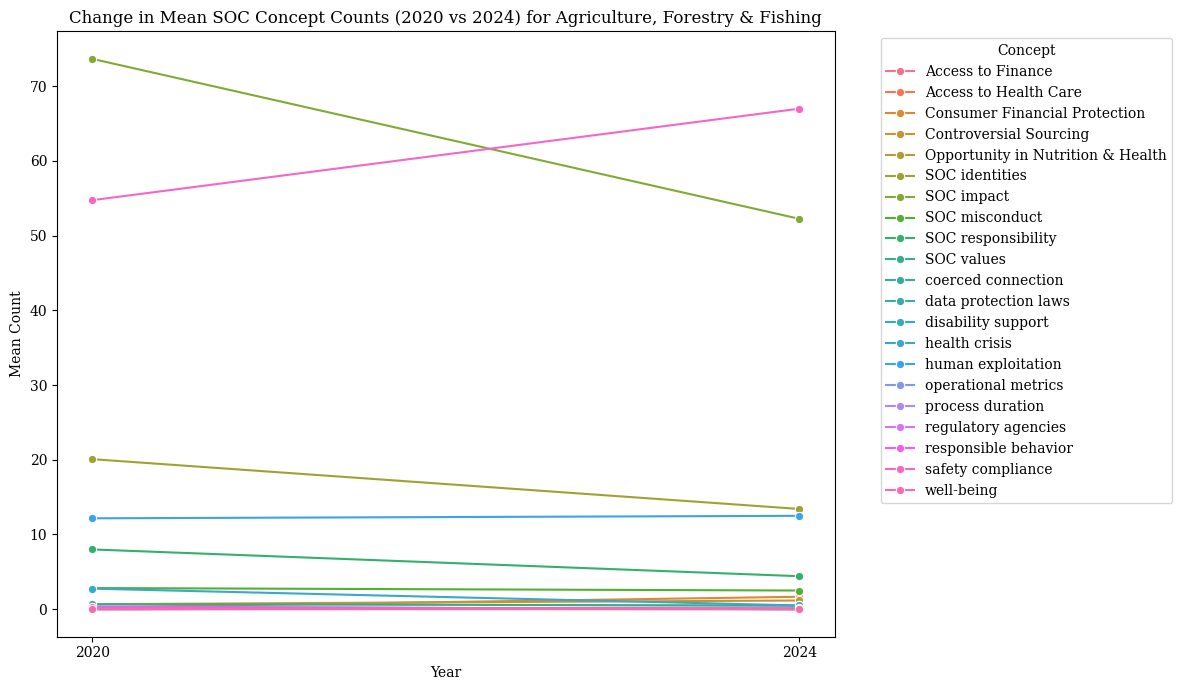

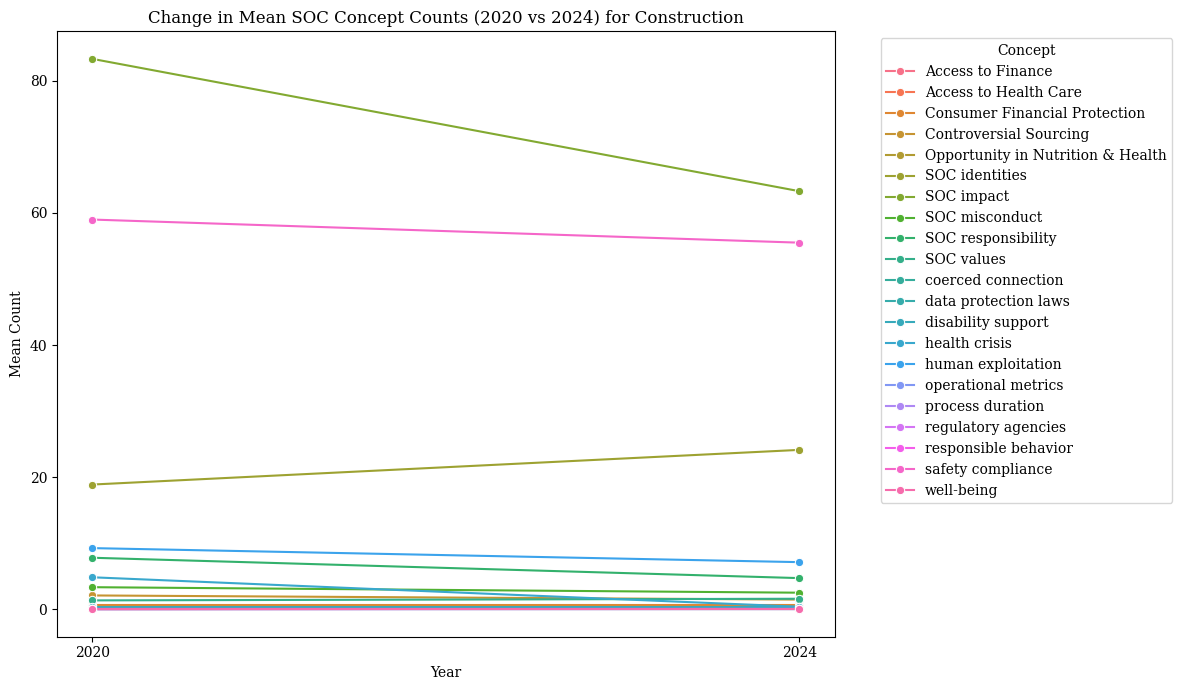

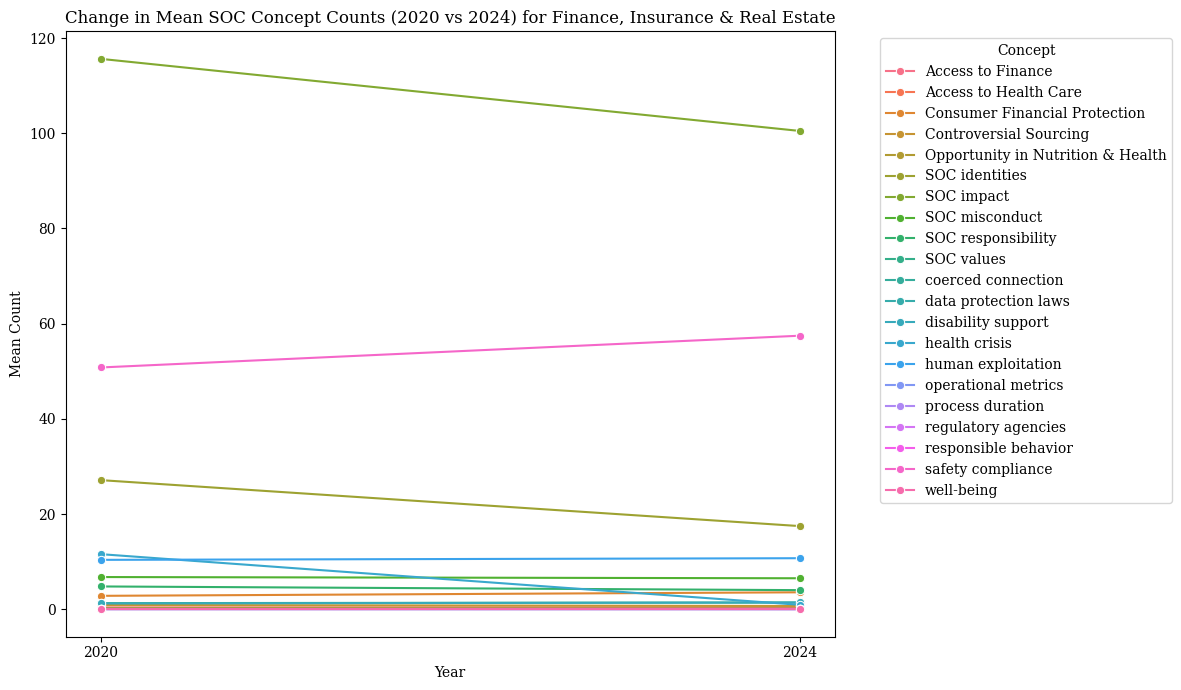

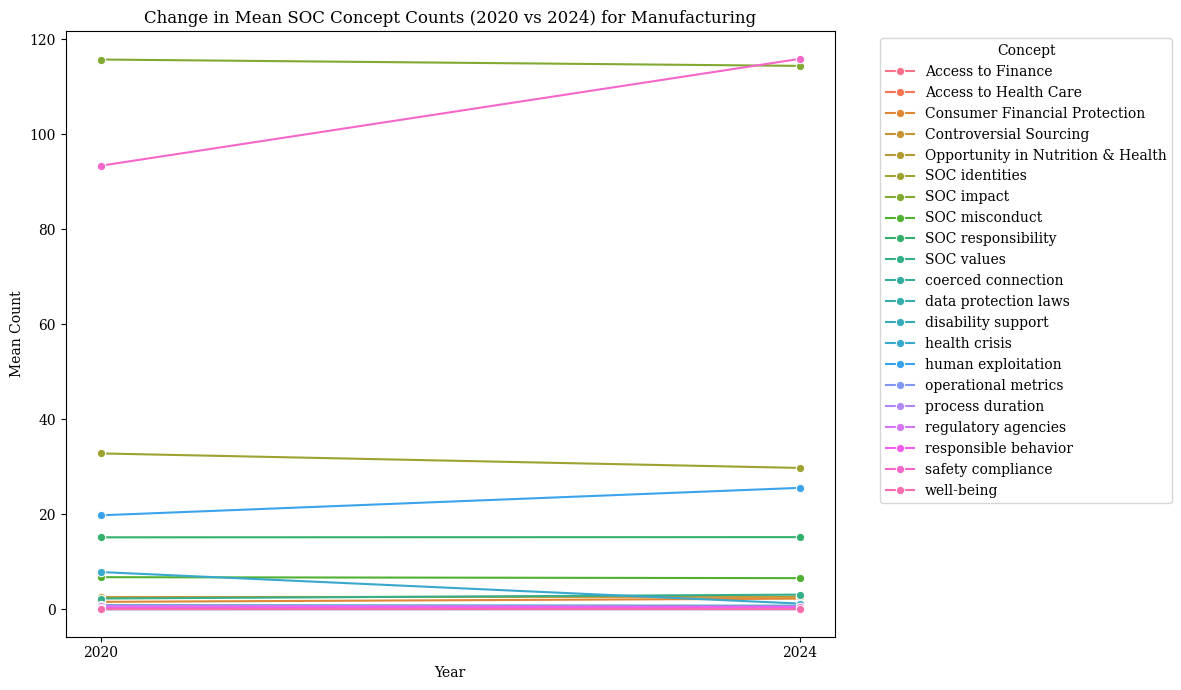

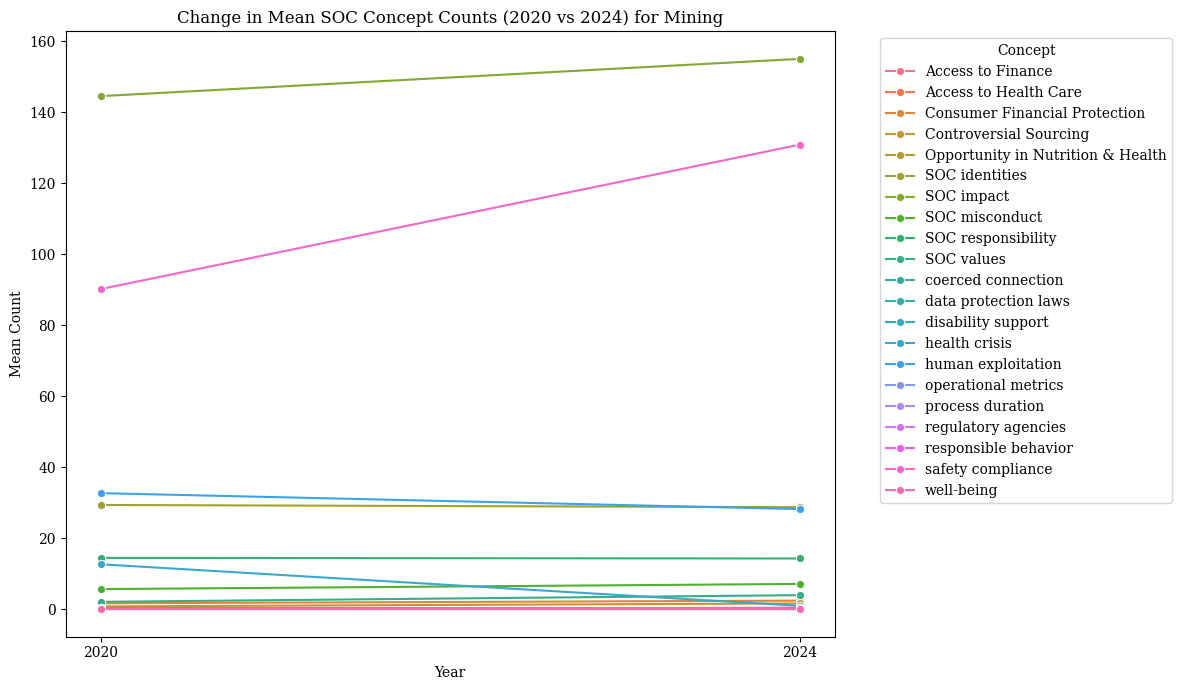

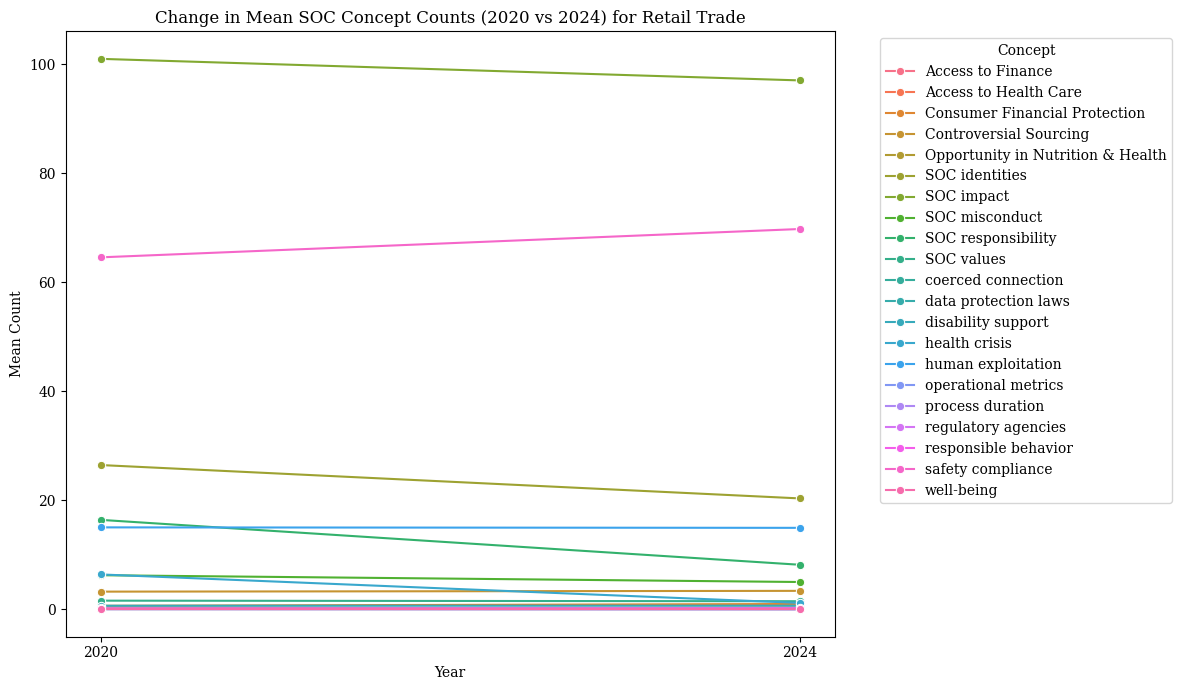

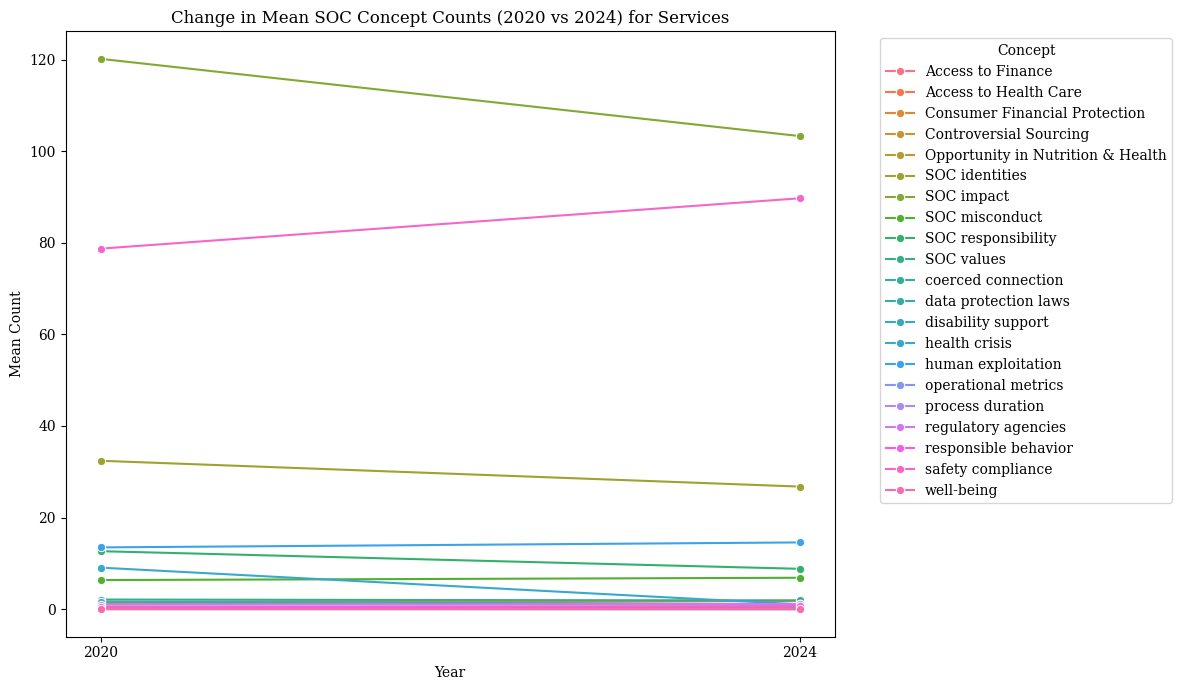

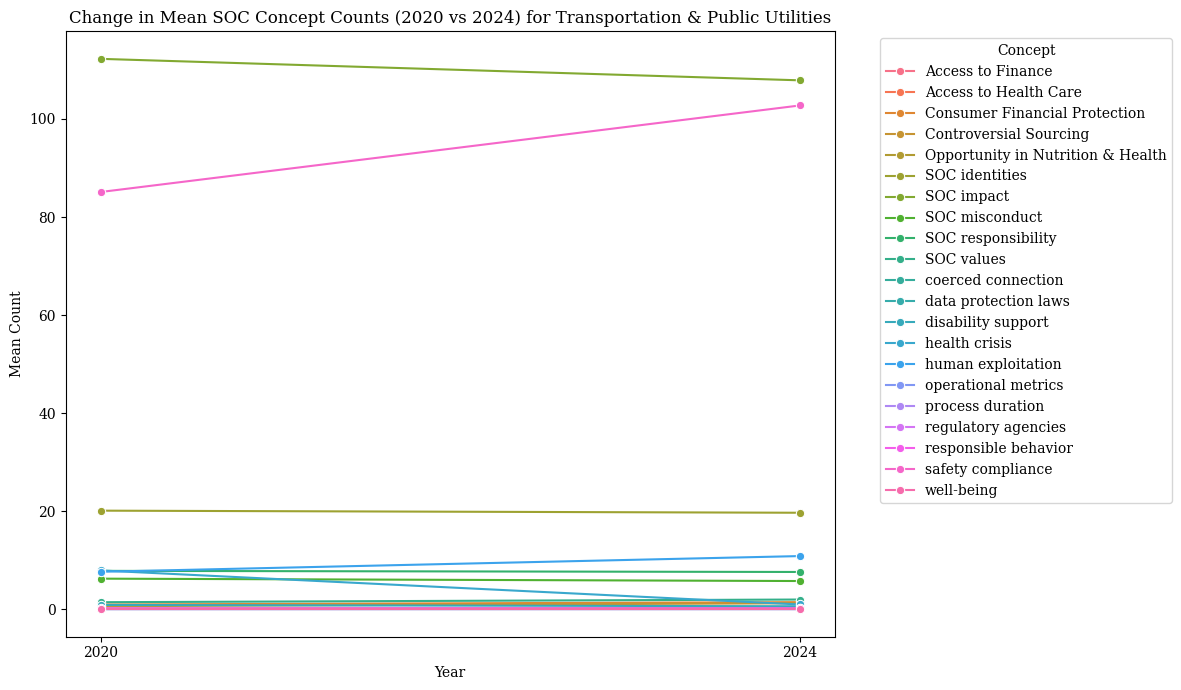

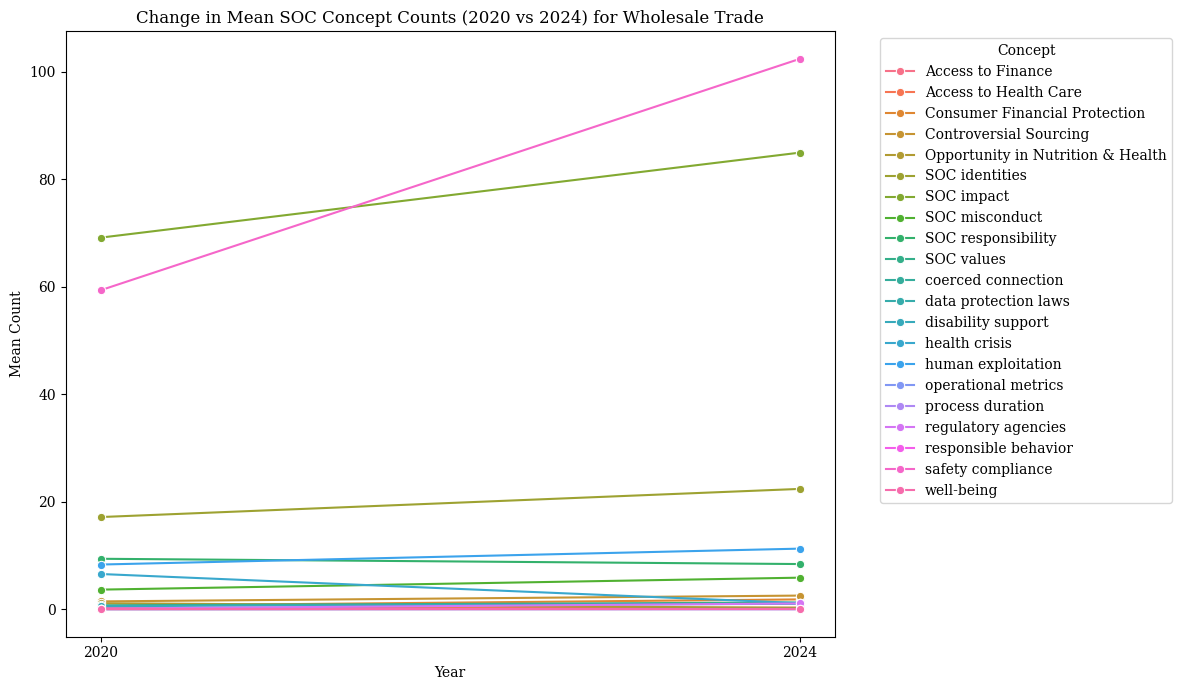

In [ ]:

# Filter the df_concept_slope_aggregated DataFrame to include only rows where the 'pillar' column is 'SOC'.
df_soc_concepts_slope = df_concept_slope_aggregated[df_concept_slope_aggregated['pillar'] == 'SOC']

# Get unique SIC divisions
sic_divisions_soc = df_soc_concepts_slope['SIC division'].unique()

# Create a slope graph for each SIC division
for sic in sic_divisions_soc:
    df_sic_soc = df_soc_concepts_slope[df_soc_concepts_slope['SIC division'] == sic]

    # Only plot if there's data for both 2020 and 2024 for at least one concept
    if len(df_sic_soc['year'].unique()) == 2:
        plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
        sns.lineplot(data=df_sic_soc, x='year', y='count', hue='concept', marker='o')

        # Set title and labels
        plt.title(f'Change in Mean SOC Concept Counts (2020 vs 2024) for {sic}')
        plt.xlabel('Year')
        plt.ylabel('Mean Count')
        plt.xticks([2020, 2024]) # Set x-axis ticks to only 2020 and 2024

        # Adjust legend and layout
        plt.legend(title='Concept', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

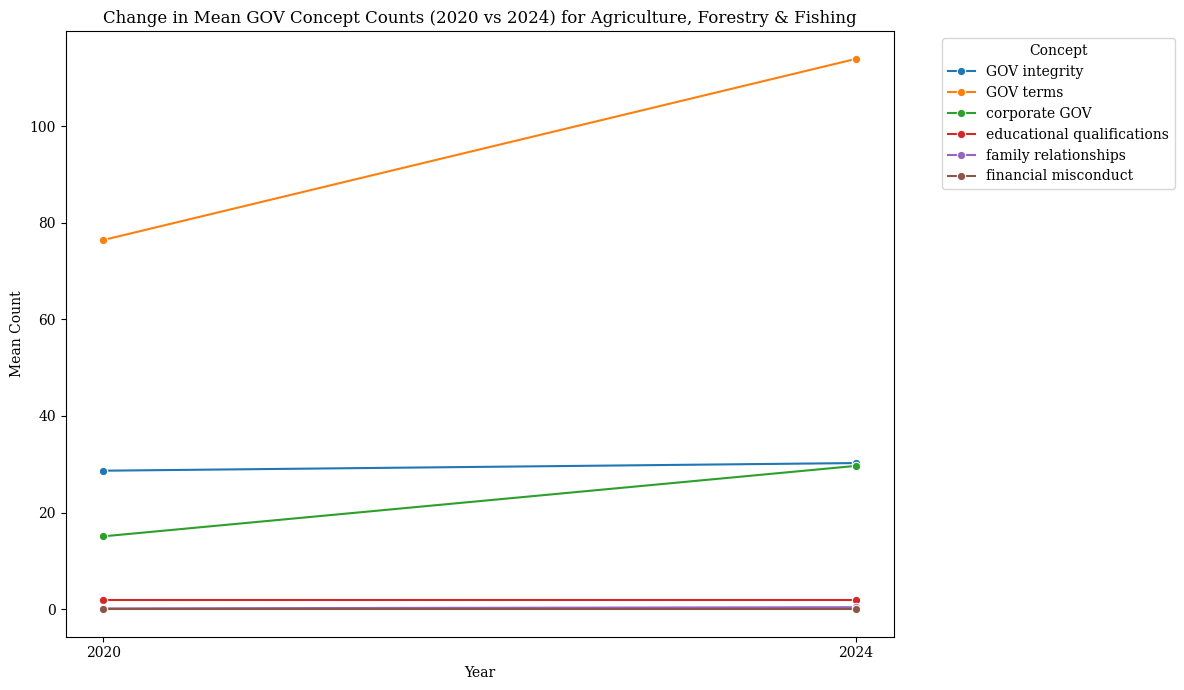

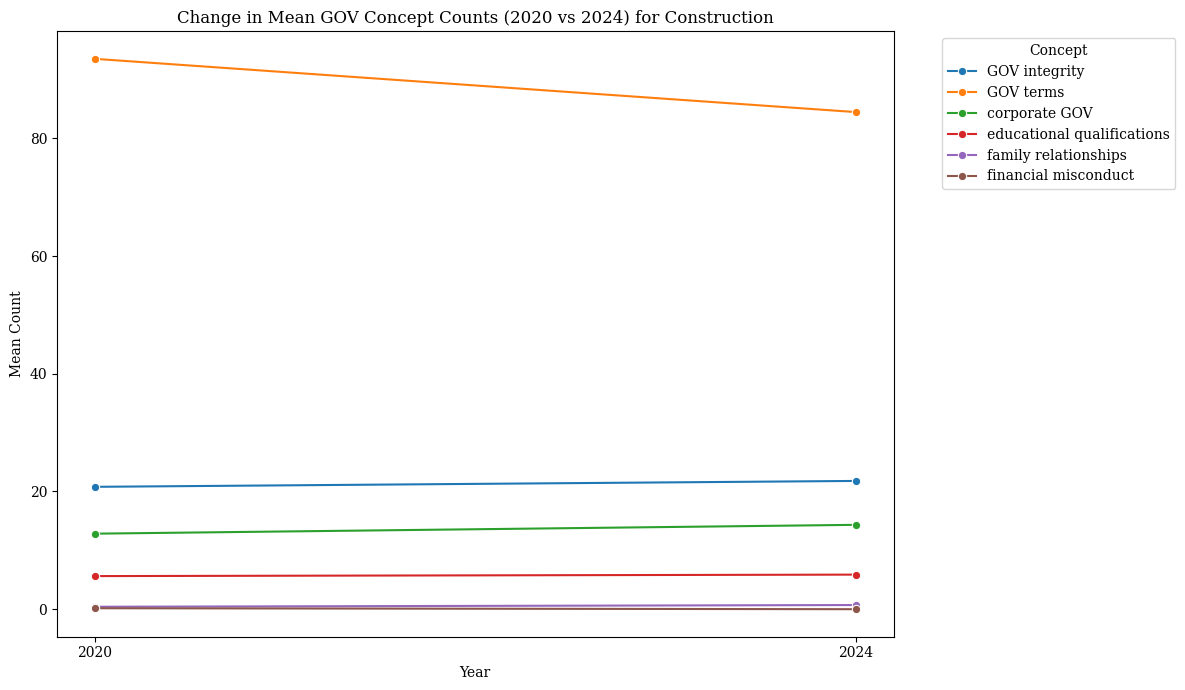

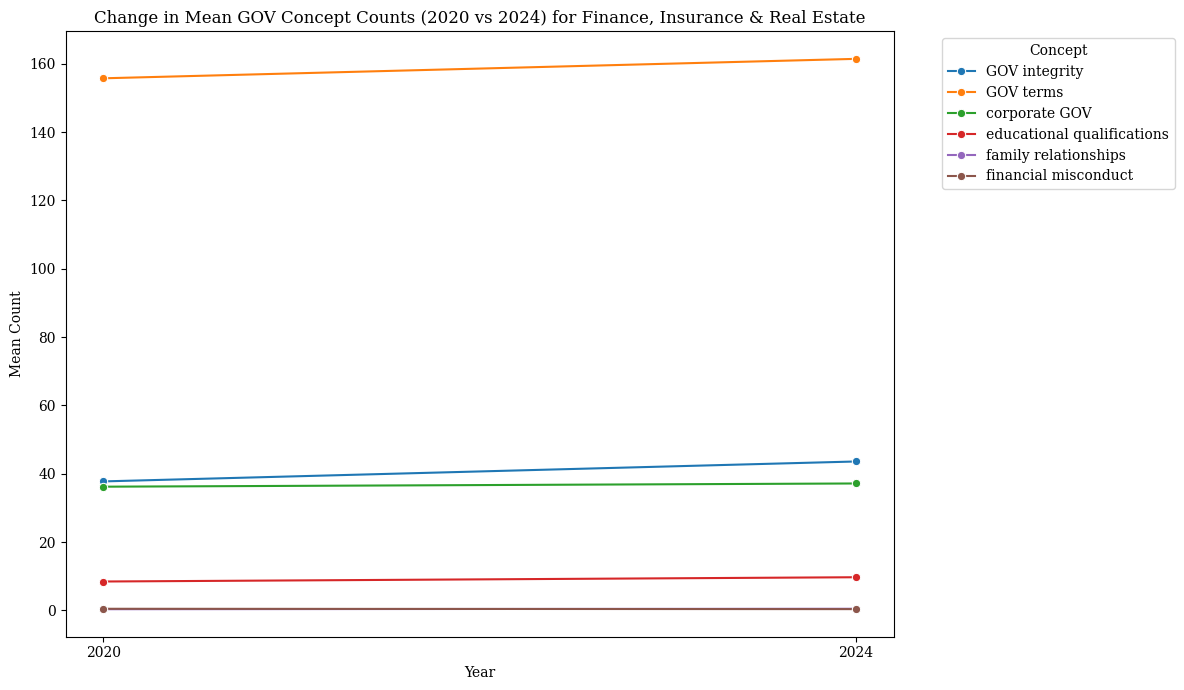

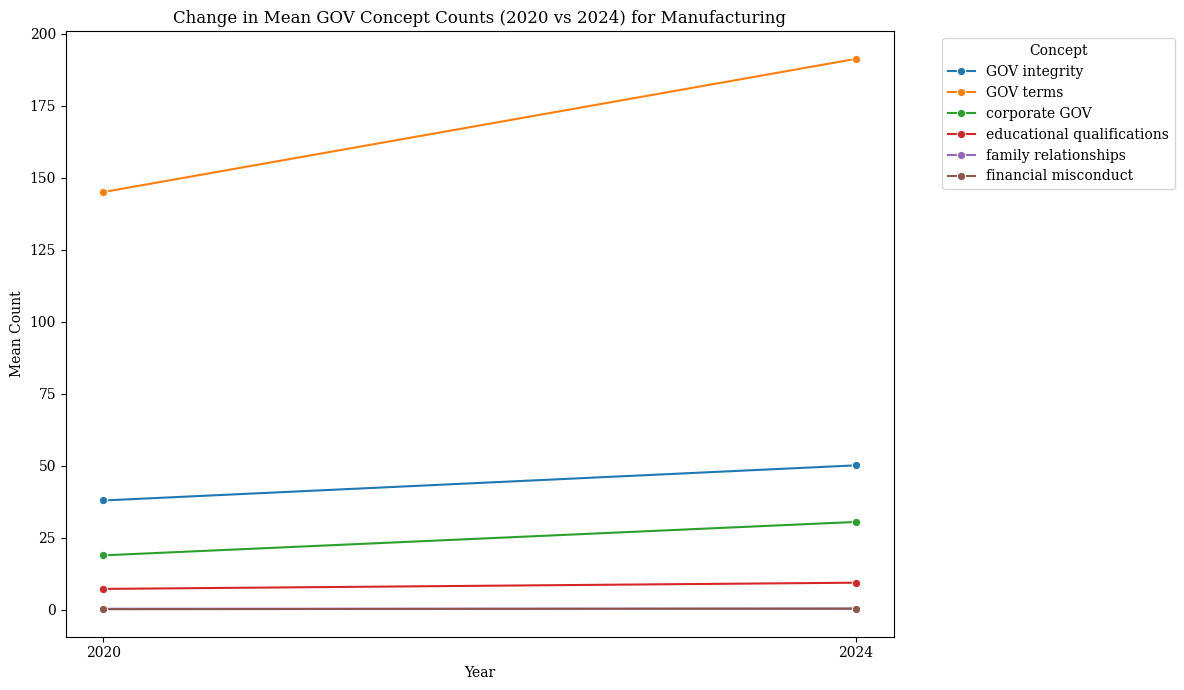

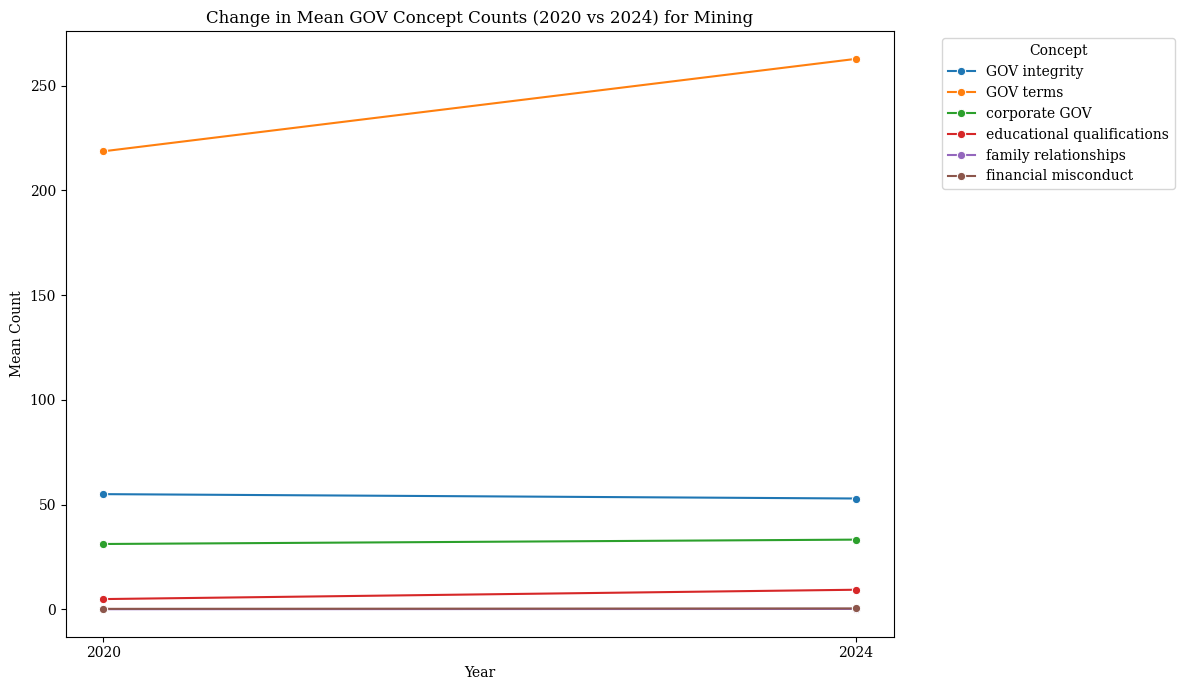

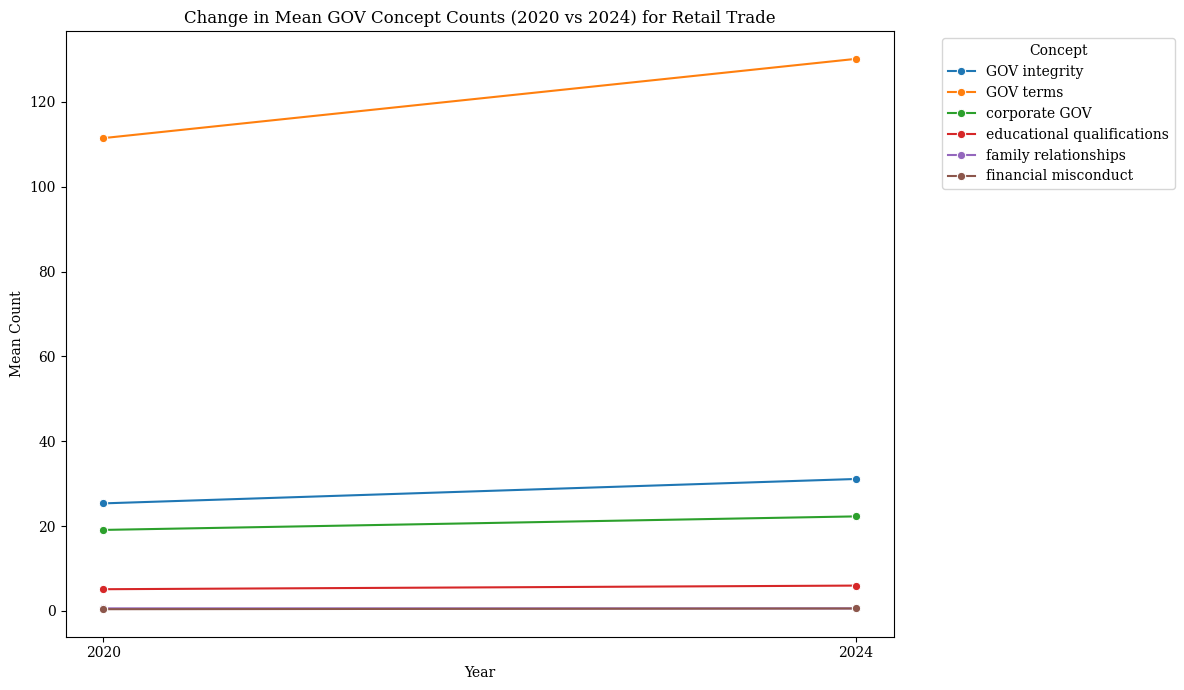

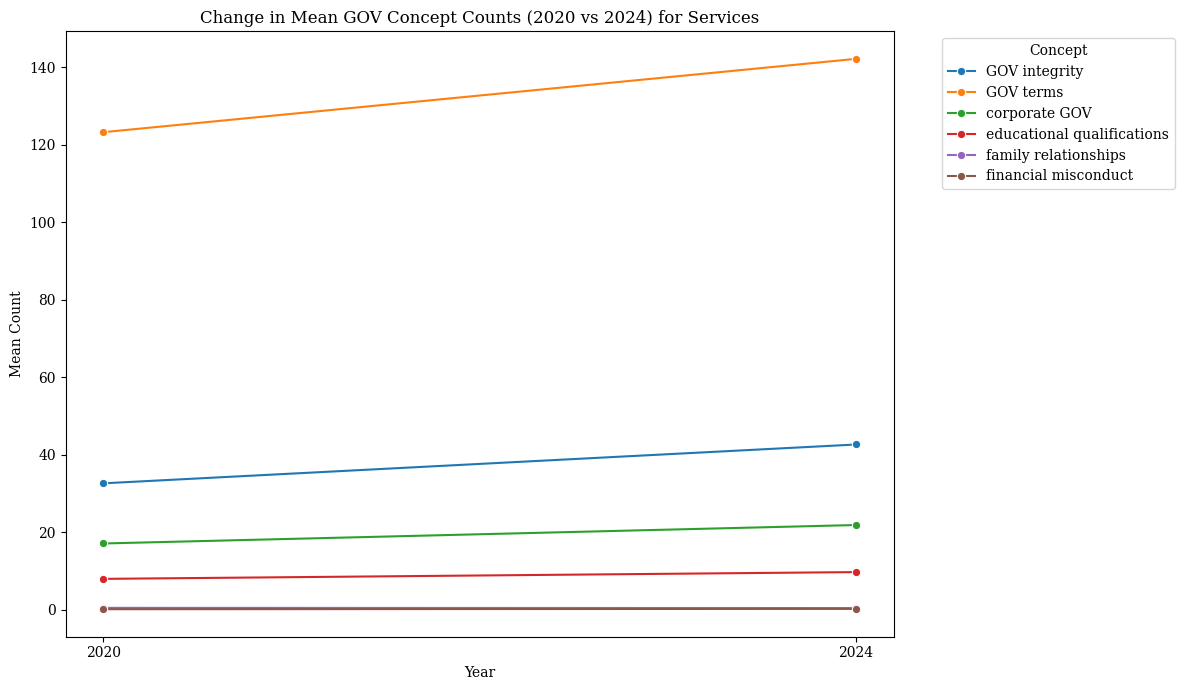

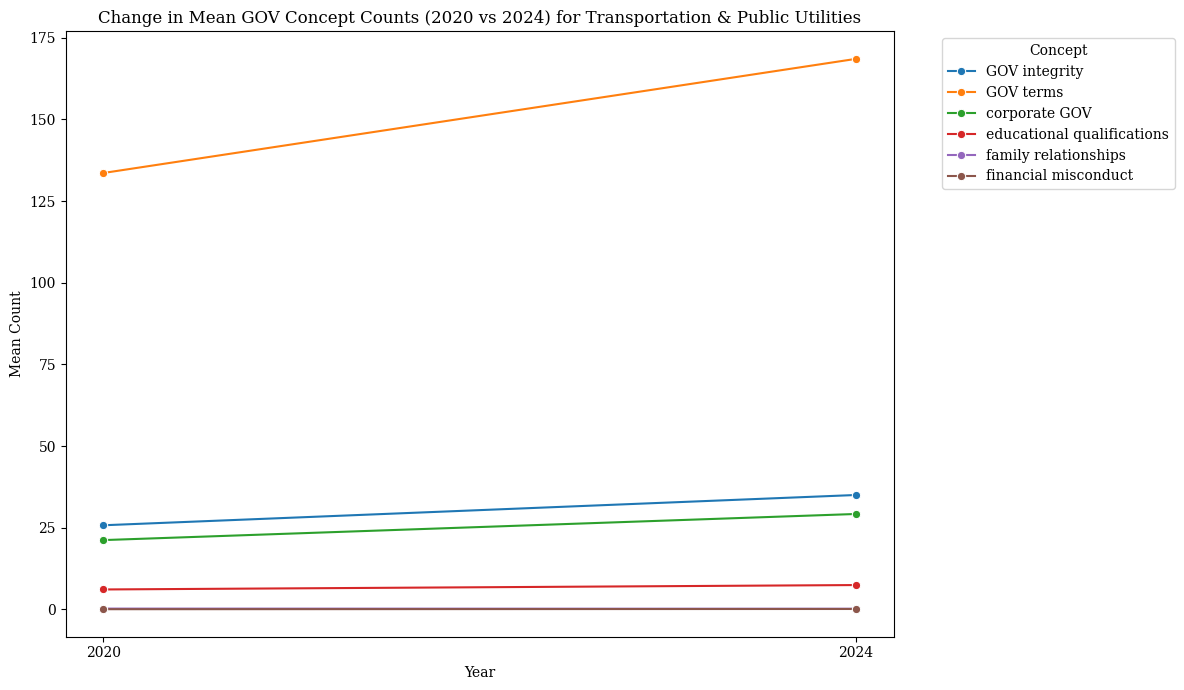

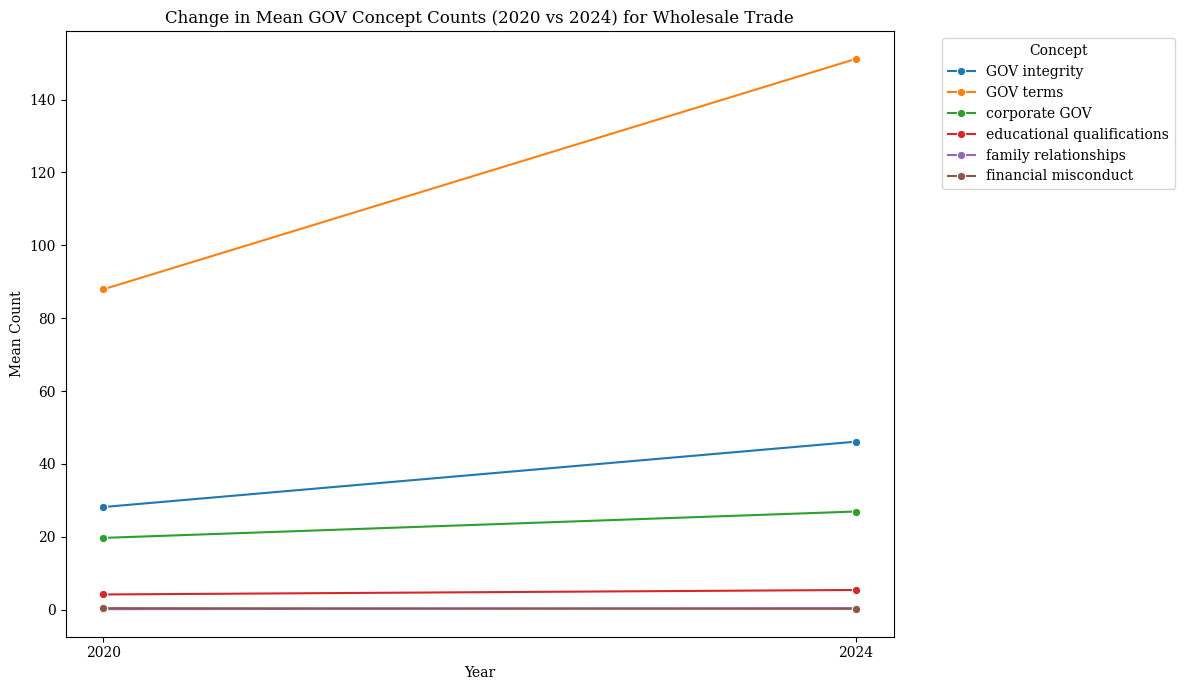

In [ ]:

# Filter the df_concept_slope_aggregated DataFrame to include only rows where the 'pillar' column is 'GOV'.
df_gov_concepts_slope = df_concept_slope_aggregated[df_concept_slope_aggregated['pillar'] == 'GOV']

# Get unique SIC divisions
sic_divisions_gov = df_gov_concepts_slope['SIC division'].unique()

# Create a slope graph for each SIC division
for sic in sic_divisions_gov:
    df_sic_gov = df_gov_concepts_slope[df_gov_concepts_slope['SIC division'] == sic]

    # Only plot if there's data for both 2020 and 2024 for at least one concept
    if len(df_sic_gov['year'].unique()) == 2:
        plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
        sns.lineplot(data=df_sic_gov, x='year', y='count', hue='concept', marker='o')

        # Set title and labels
        plt.title(f'Change in Mean GOV Concept Counts (2020 vs 2024) for {sic}')
        plt.xlabel('Year')
        plt.ylabel('Mean Count')
        plt.xticks([2020, 2024]) # Set x-axis ticks to only 2020 and 2024

        # Adjust legend and layout
        plt.legend(title='Concept', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

### Displaying in a facet grid

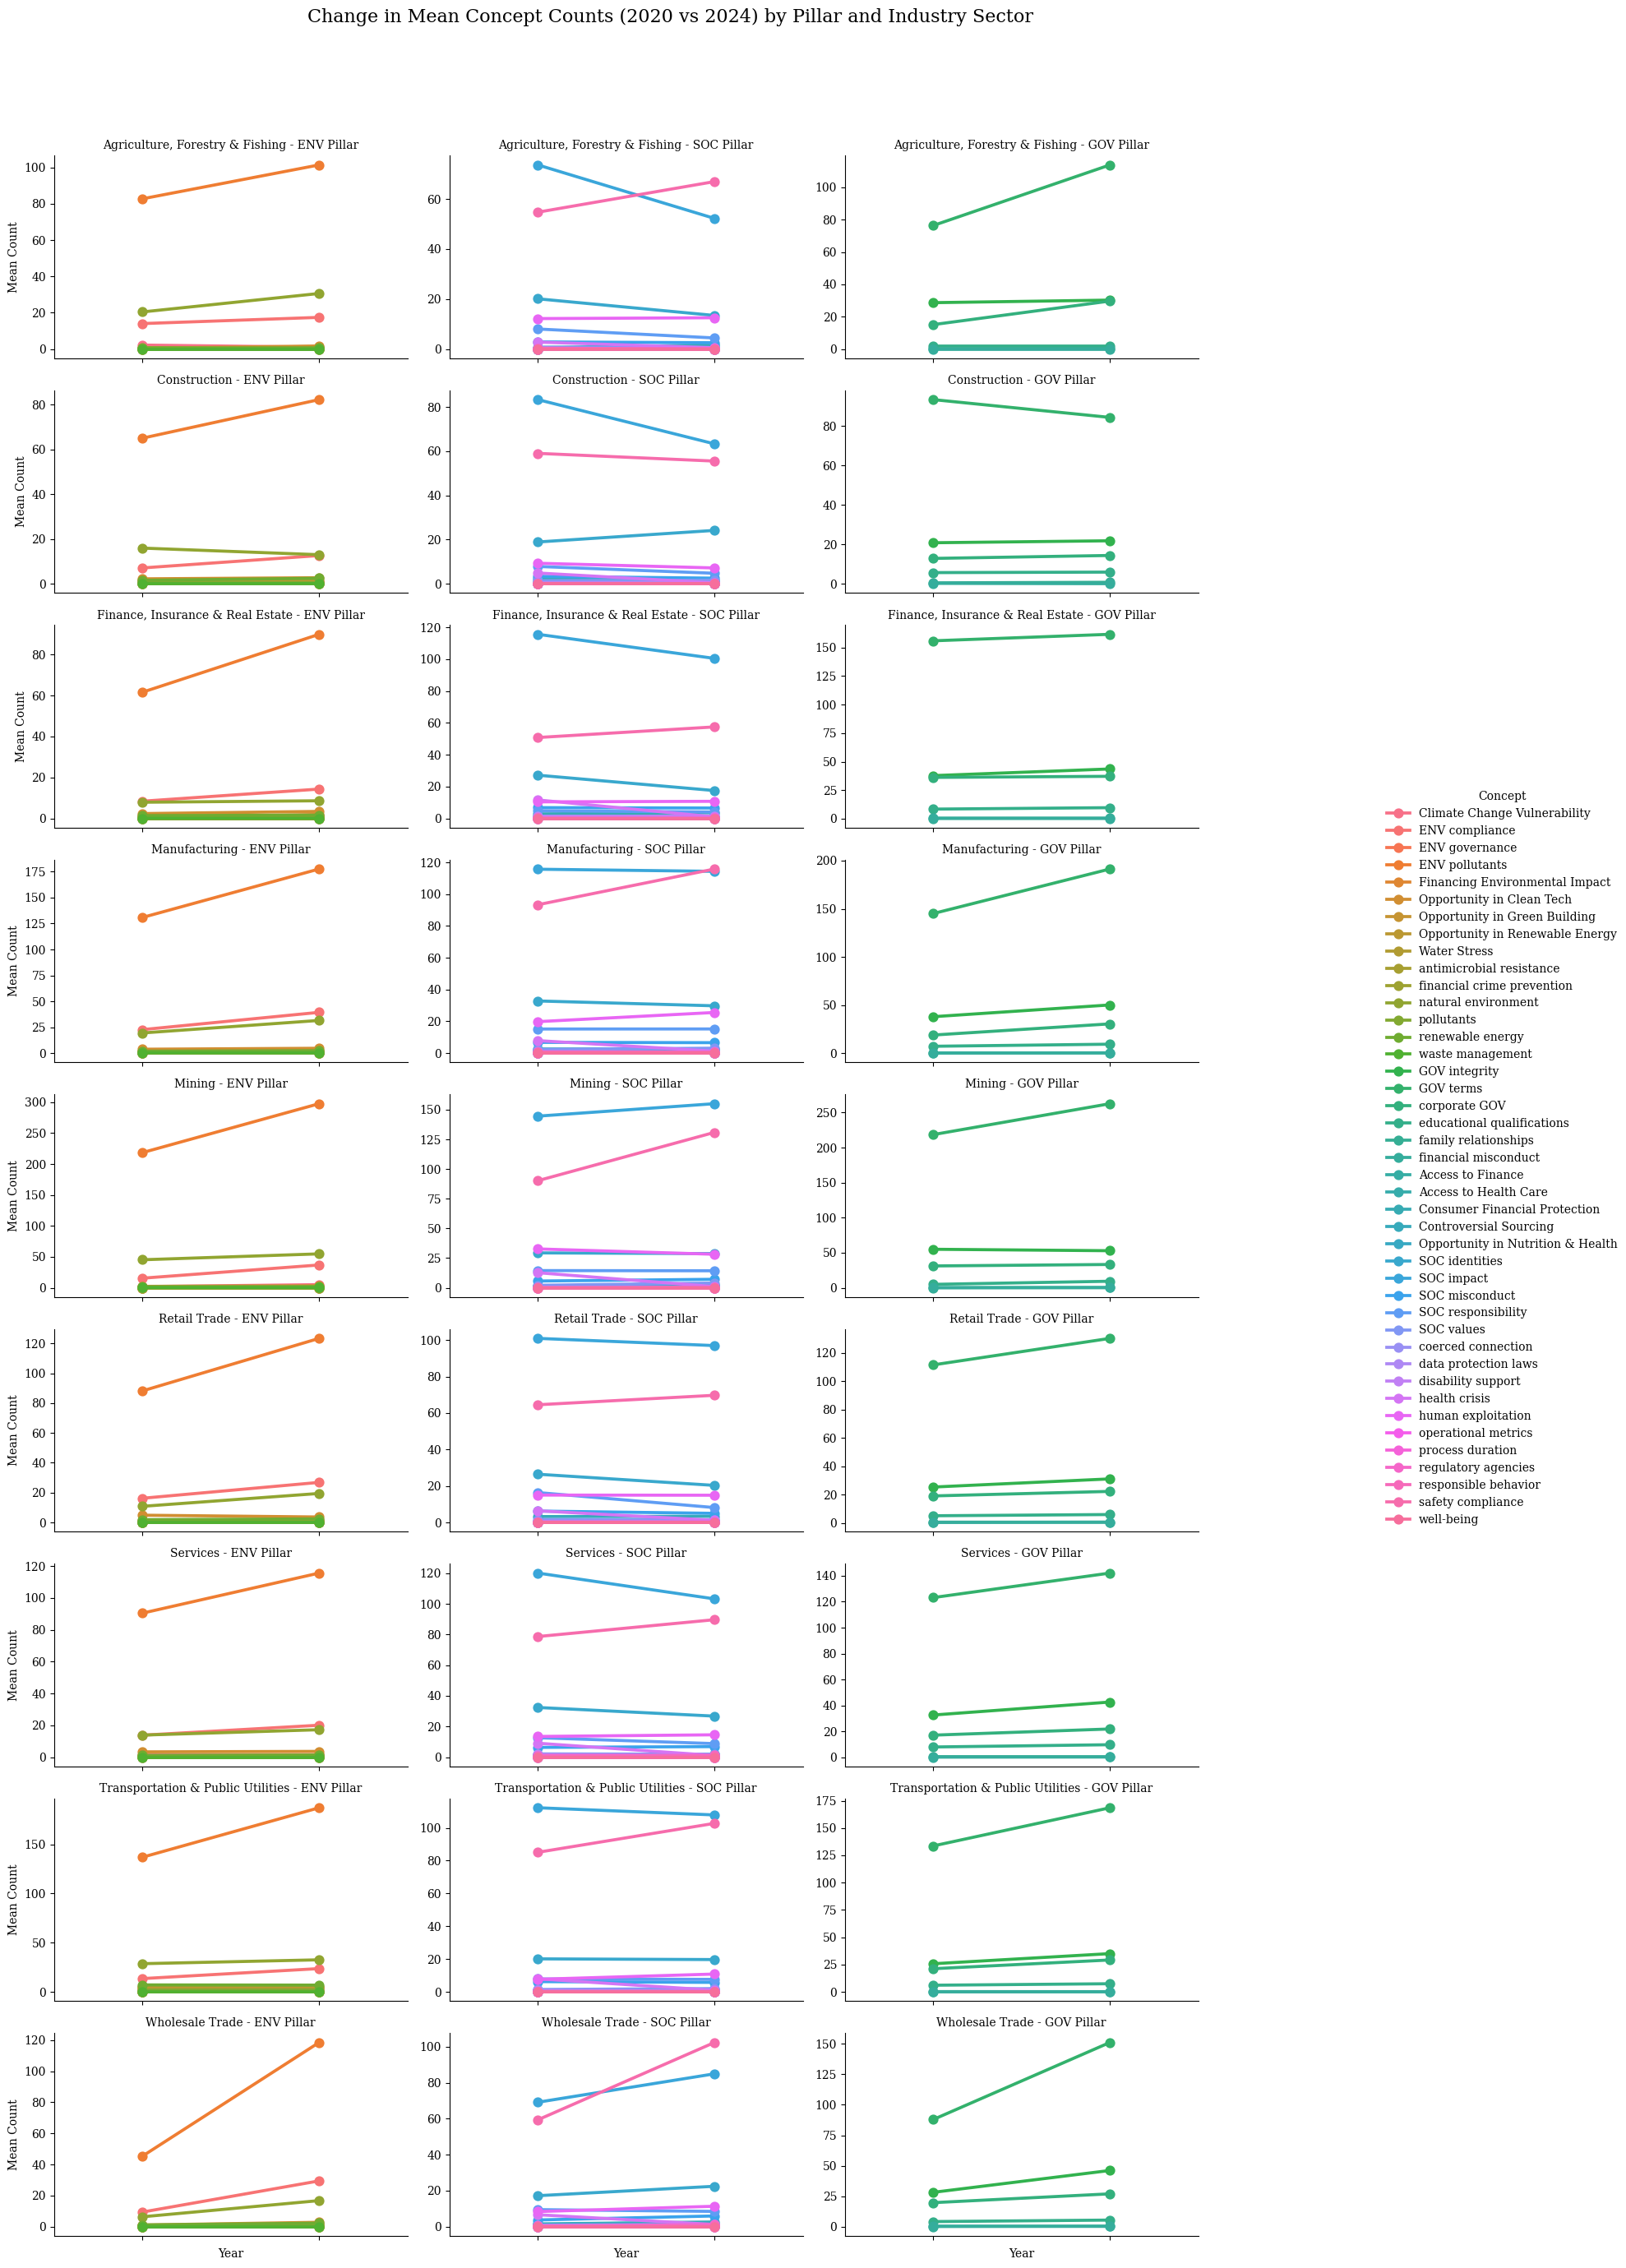

In [ ]:
# Get unique SIC division values for consistent row ordering
sic_divisions_order = df_concept_slope_aggregated['SIC division'].unique()

# Create a facet grid using seaborn.catplot
g = sns.catplot(
    data=df_concept_slope_aggregated,
    x='year',
    y='count',
    hue='concept',
    col='pillar',
    row='SIC division',
    kind='point',  # For slope graphs
    col_order=['ENV', 'SOC', 'GOV'], # Ensure consistent pillar order
    row_order=sic_divisions_order,  # Ensure consistent SIC division order
    height=3,     # Height of each facet
    aspect=1.5,   # Aspect ratio of each facet
    sharey=False, # Allow different y-axis scales for better readability within rows
    legend=True
)

# Set titles and labels for each subplot
g.set_axis_labels("Year", "Mean Count")
g.set_titles(template="{row_name} - {col_name} Pillar") # Modified to include {row_name}

# Adjust the main title for the entire figure
plt.suptitle('Change in Mean Concept Counts (2020 vs 2024) by Pillar and Industry Sector',
             y=1.02, # Adjust vertical position of suptitle
             fontsize=16)

# Rotate x-axis labels for better readability
g.set_xticklabels(rotation=45, ha='right')

# Adjust legend
g.legend.set_title('Concept')
g.legend.set_bbox_to_anchor((1.02, 0.5)) # Position the legend to the right
g.legend.set_loc('center left')       # Anchor the legend's center-left to this position

# Ensure tight layout, adjusting rect to make space for the legend
plt.tight_layout(rect=[0, 0, 0.9, 0.98]) # Adjusted rect to leave space on the right
plt.show()

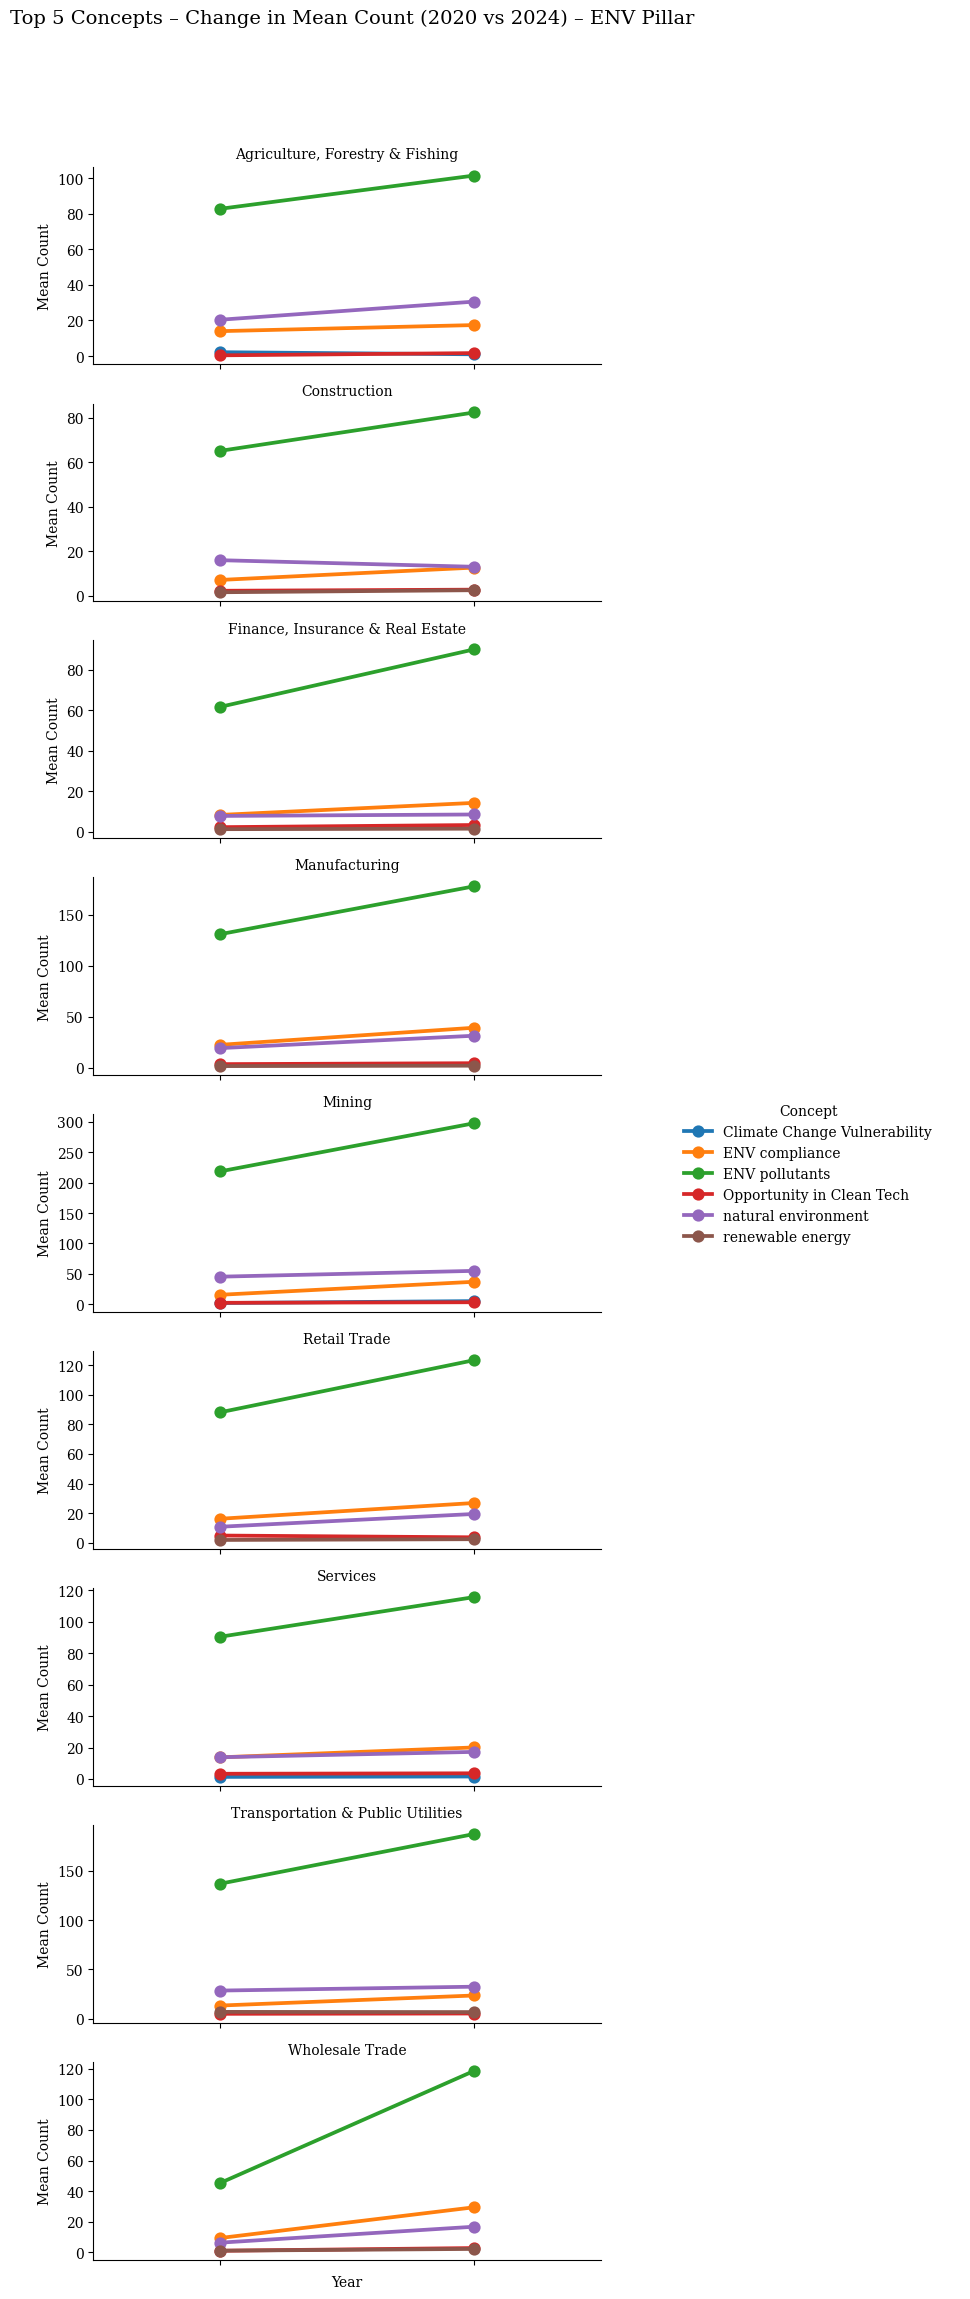

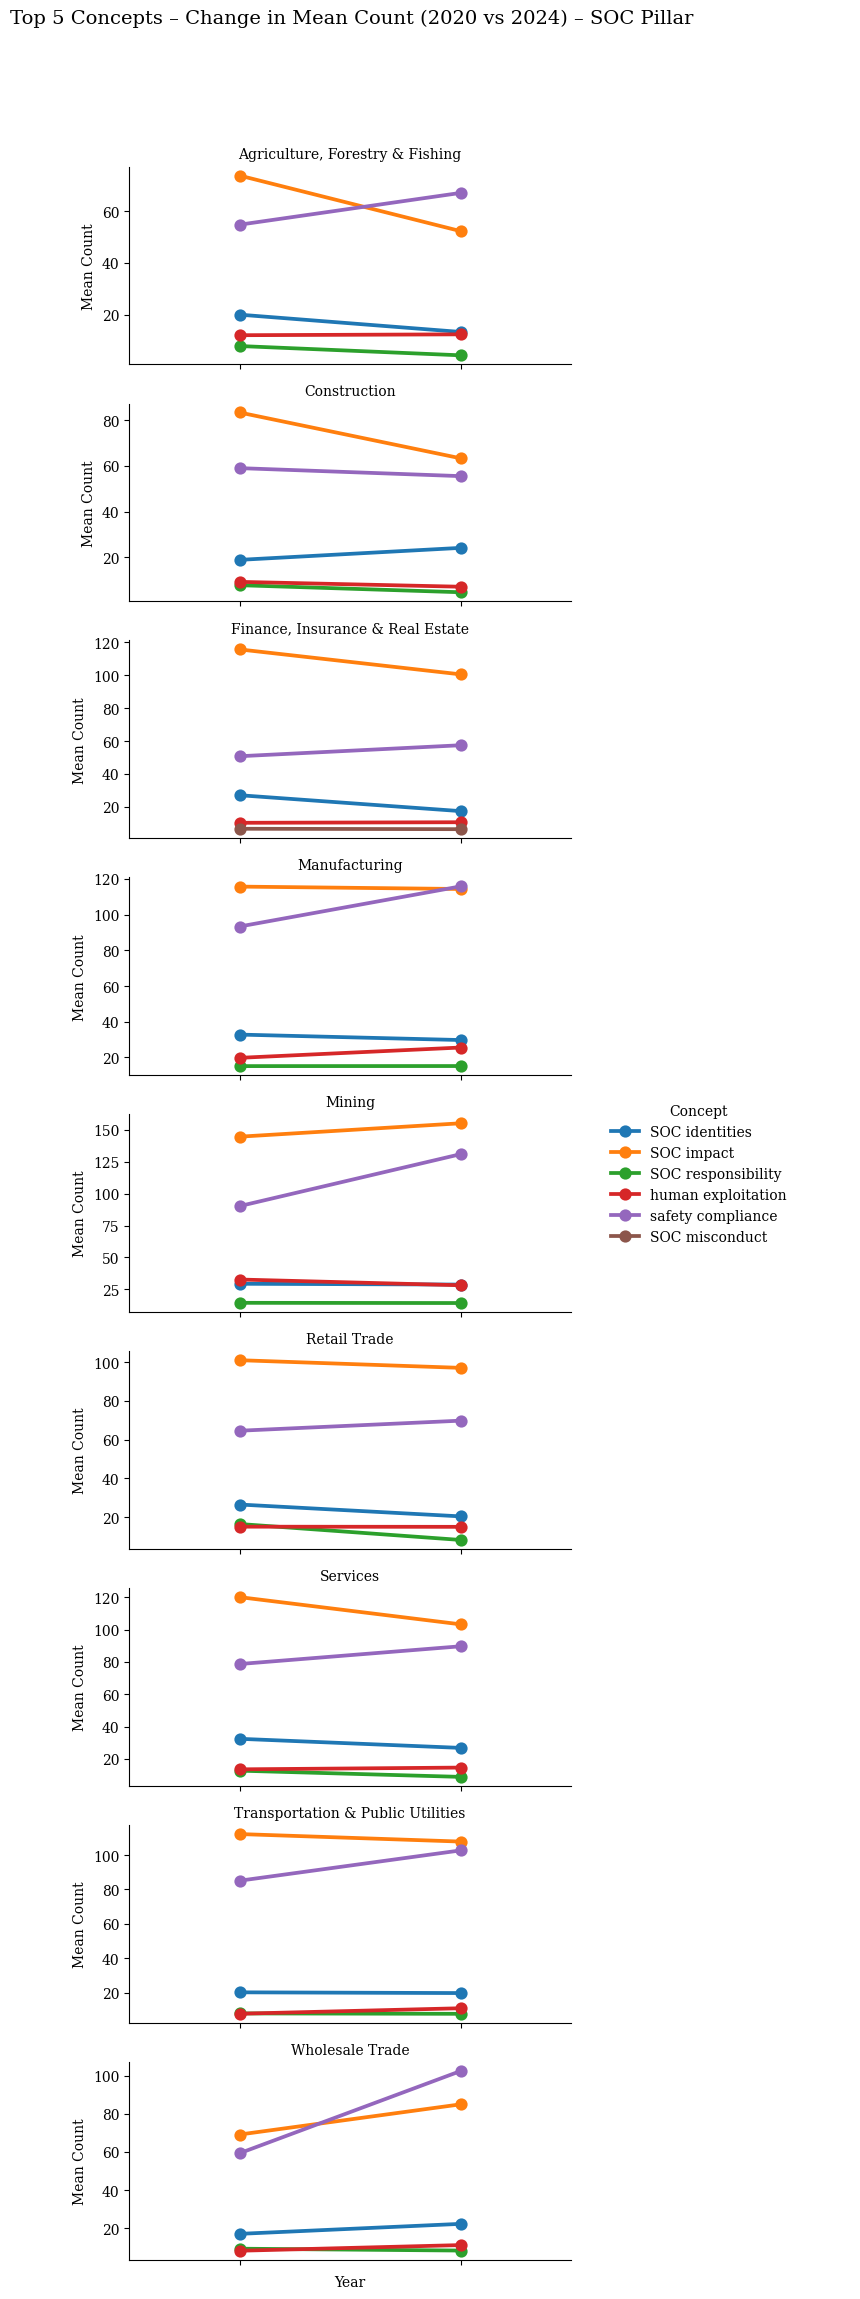

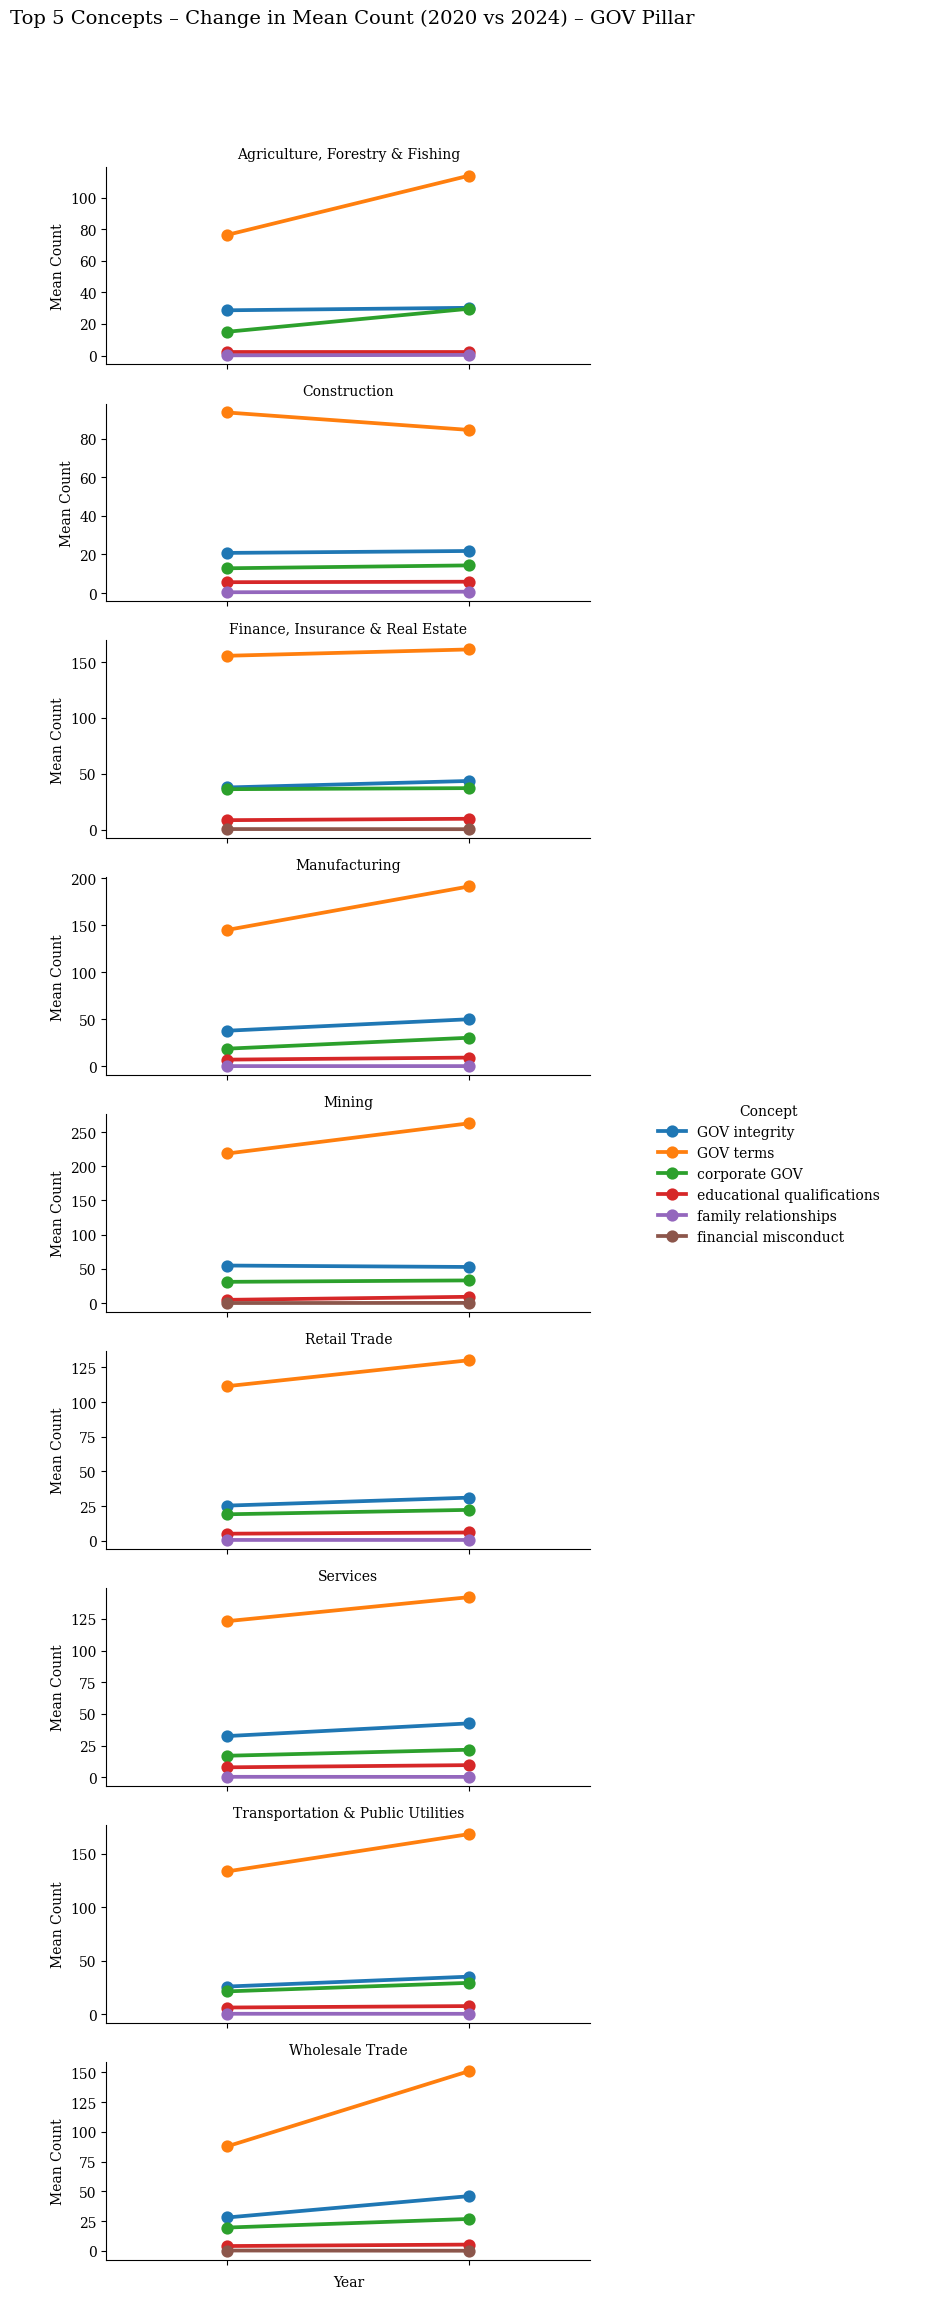

In [ ]:
# ====================================================
# 1. Select top 5 concepts per SIC division × pillar
#    (based on mean count across years)
# ====================================================

top_n = 5

# Compute mean count per concept (across years)
concept_mean = (
    df_concept_slope_aggregated
    .groupby(["SIC division", "pillar", "concept"], as_index=False)["count"]
    .mean()
)

# For each SIC division × pillar, keep top N concepts
top_concepts = (
    concept_mean
    .sort_values(["SIC division", "pillar", "count"], ascending=[True, True, False])
    .groupby(["SIC division", "pillar"])
    .head(top_n)
    [["SIC division", "pillar", "concept"]]
)

# Filter original slope data to only those top concepts
df_slope_top = df_concept_slope_aggregated.merge(
    top_concepts,
    on=["SIC division", "pillar", "concept"],
    how="inner"
)

# Optional: set consistent SIC division order
sic_divisions_order = df_slope_top["SIC division"].unique().tolist()

# ====================================================
# 2. Slopegraphs: one pillar at a time (ENV, SOC, GOV)
# ====================================================

for p in ["ENV", "SOC", "GOV"]:
    subset = df_slope_top[df_slope_top["pillar"] == p].copy()
    if subset.empty:
        continue  # skip if no data for this pillar

    g = sns.catplot(
        data=subset,
        x="year",
        y="count",
        hue="concept",
        row="SIC division",
        kind="point",          # slope-style
        row_order=sic_divisions_order,  # consistent industry order
        height=2.5,
        aspect=1.6,
        sharey=False,
        legend=True
    )

    g.set_axis_labels("Year", "Mean Count")
    g.set_titles(template="{row_name}")  # each row title = SIC division
    g.fig.suptitle(
        f"Top {top_n} Concepts – Change in Mean Count (2020 vs 2024) – {p} Pillar",
        y=1.02,
        fontsize=14
    )

    # Rotate x labels a bit if needed
    g.set_xticklabels(rotation=0)

    # Adjust legend
    if g._legend is not None:
        g._legend.set_title("Concept")
        g._legend.set_bbox_to_anchor((1.02, 0.5))
        g._legend.set_loc("center left")

    plt.tight_layout(rect=[0, 0, 0.9, 0.98])
    plt.show()
